In [1]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=3)     # linewidth

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_323760/2279324654.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_323760/2279324654.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_323760/2279324654.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_323760/2279324654.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


## Prepare data
### (Comment: when creating the lagged data we drop some values in $y$ and $u$ and thus loose the characteristic spectrum of PRBS. If instead of cutting the table short, we loop it (so that the we retain the full PRSB signal, we get a very similar performance).

In [2]:
# make a copy of the training and test data
df_2 = copy.deepcopy(df2)
df_1 = copy.deepcopy(df1)

# define lags
lag = 3

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, lag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_2['y_lag' + str(i)] = df_2['y'].shift(i)
for i in range(1, lag+1):
    df_2['u_lag' + str(i)] = df_2['u'].shift(i)
for i in range(1, lag+1):
    df_1['y_lag' + str(i)] = df_1['y'].shift(i)
for i in range(1, lag+1):
    df_1['u_lag' + str(i)] = df_1['u'].shift(i)

# dropping NA values (created due to shifting)
df_2 = df_2.dropna()
df_1 = df_1.dropna()

# The four-step IV

# Step 1: estimate the regressors via LS

In [3]:
# # using a function
# model_LS_01 = IV2SLS(dependent=df_2['y'],
#                     exog=df_2[lagged_y+lagged_u],
#                     endog=None,
#                     instruments=None) # same as sm.OLS(df_2['y'],df_2[lagged_y+lagged_u])
# results_01 = model_LS_01.fit()
# #save results
# theta_01_df = results_01.params
# theta_01 = np.asarray(theta_01_df)
# print(theta_01_df)

# solve by hand
X_1 = np.asarray(df_2[lagged_y + lagged_u])
y_1 = np.asarray(df_2['y'])
theta_01 = np.linalg.inv(X_1.T.dot(X_1)).dot(X_1.T).dot(y_1)
print(theta_01)

def simulate(theta, y0, u):
    theta = np.asarray(theta) # shape (lag+lag,)
    y0 = np.asarray(y0)       # shape (lag,)
    u = np.asarray(u)         # shape (l, lag)

    l = u.shape[0]
    y = copy.deepcopy(y0)

    for i in range(l):
        y_next = np.concatenate((y[:lag],u[i,:])) @ theta # one step ahead prediction
        y = np.concatenate(([y_next],y))

    return y[::-1][lag:]

[ 1.47418444 -0.30644589 -0.22119435 -0.00297311  0.01607561  0.04407594]


## Step 2.1: Simulate the model on training data

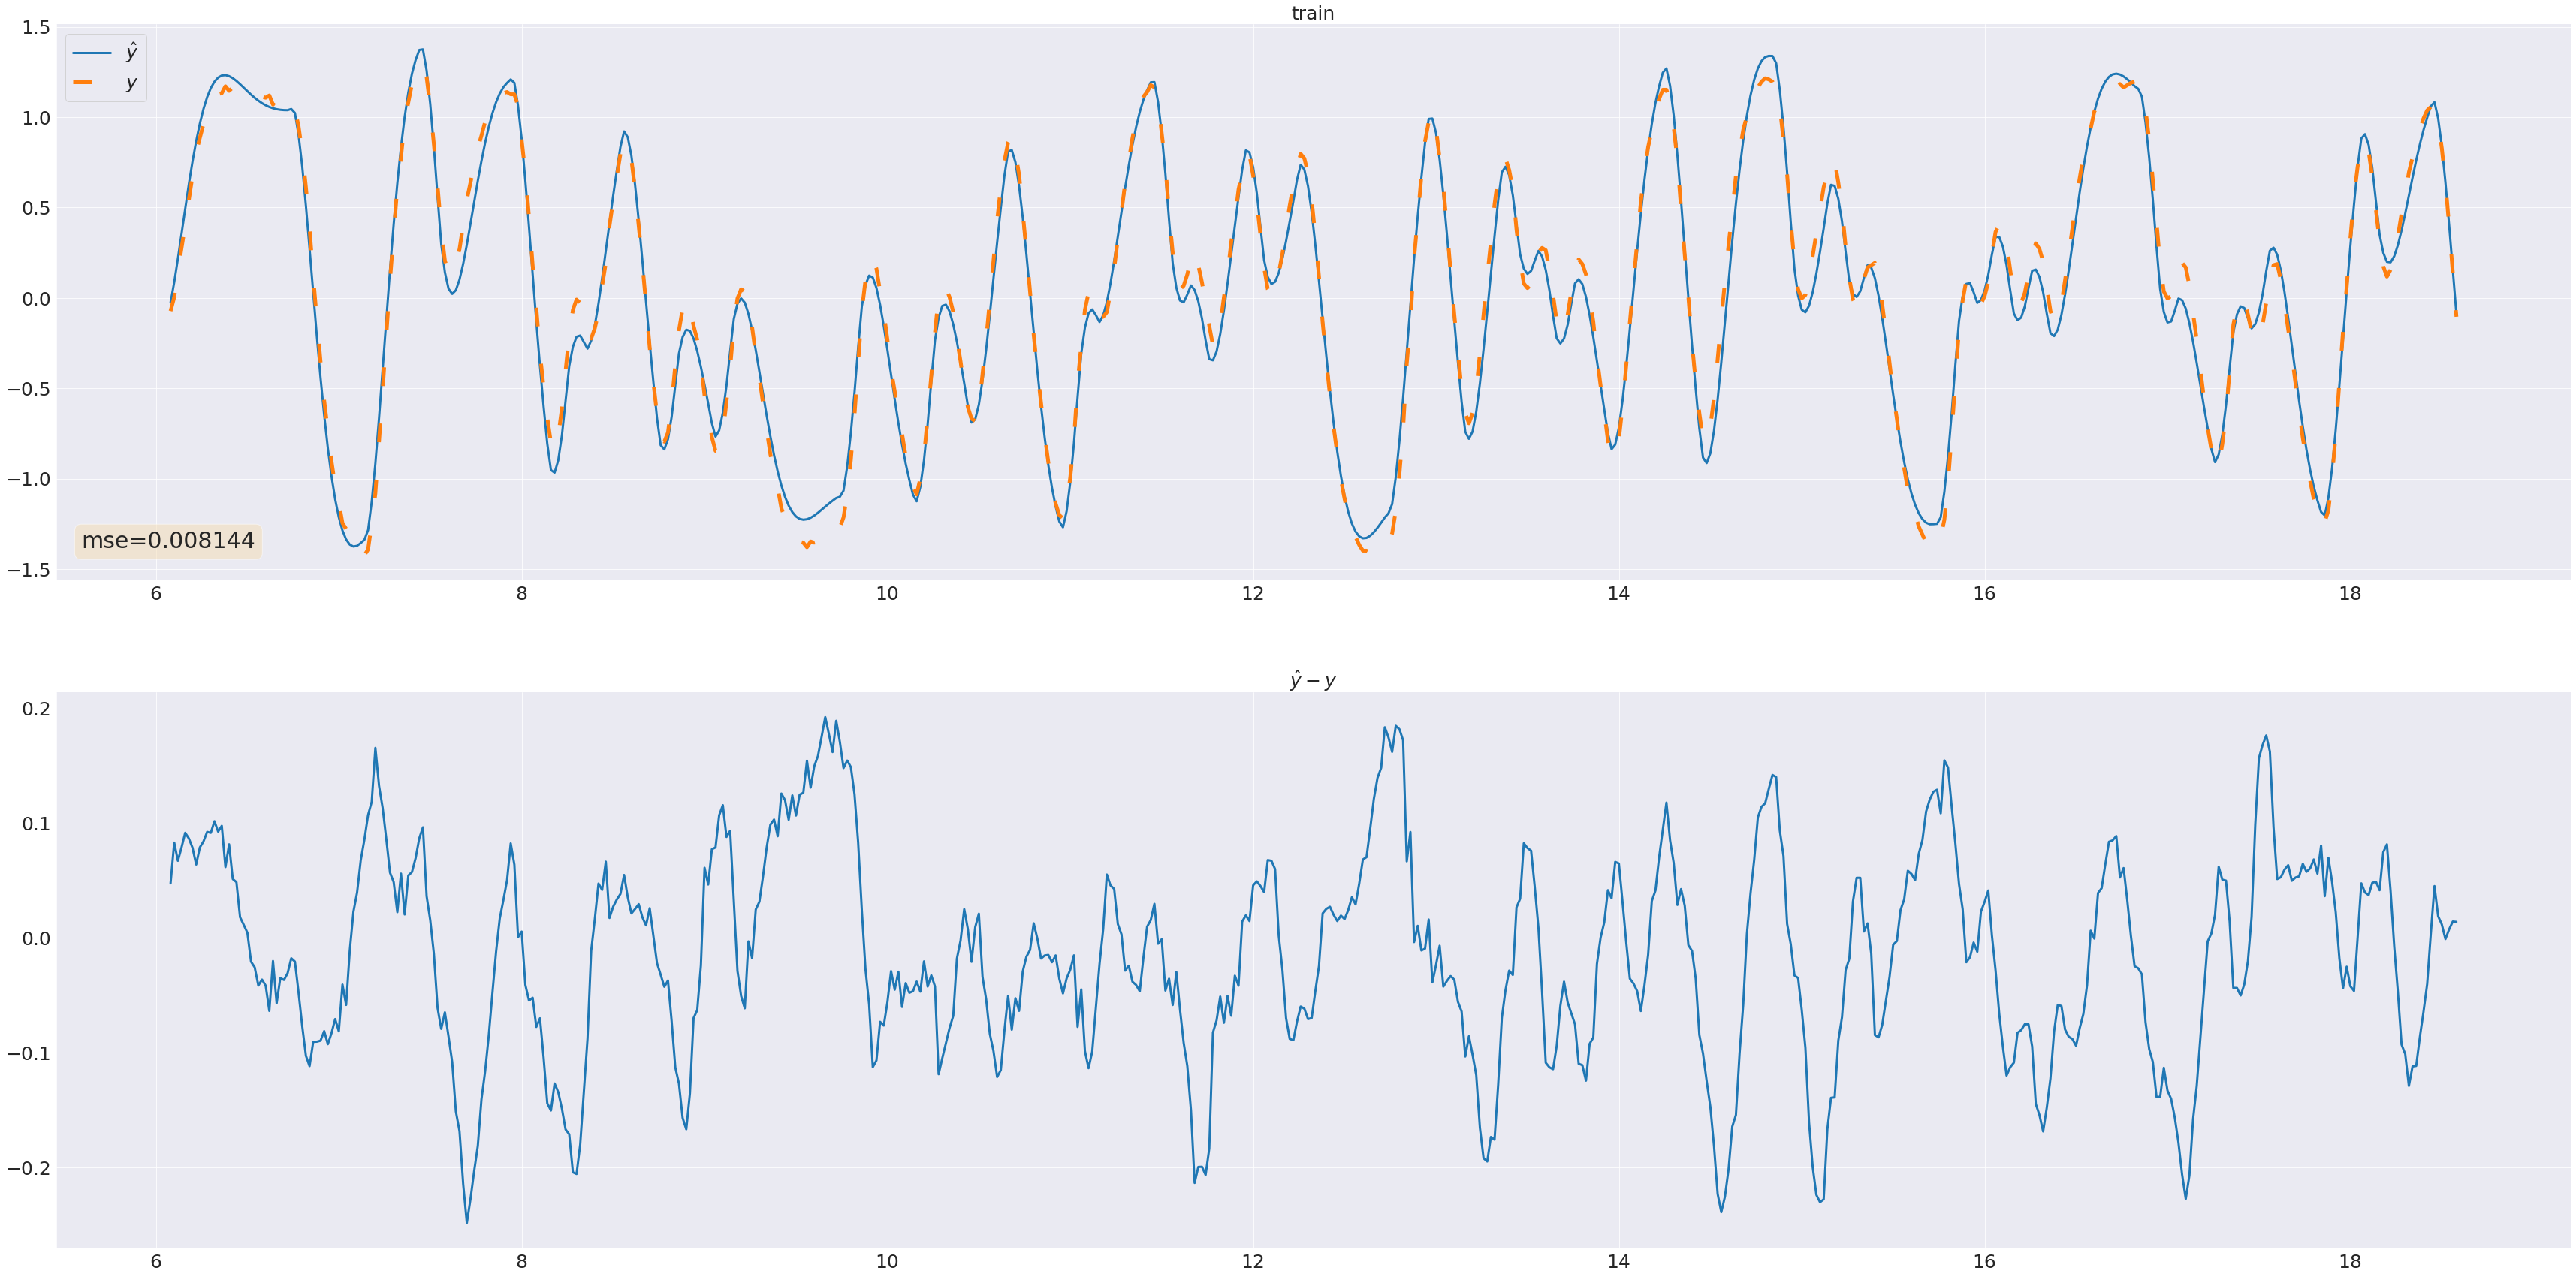

In [4]:
# simulate model on training data
df_2['x'] = simulate(theta_01, df_2[lagged_y].iloc[0, :], df_2[lagged_u])
#df_1['x'] = np.asarray(df_1[lagged_y+lagged_u]) @ theta_1

# training error
mse_train_1 = mean_squared_error(df_2['x'], df_2['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_2['time']), df_2['x'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_2['time']), np.asarray(df_2['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_1,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_2['time']), df_2['x'] - np.asarray(df_2['y']))
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

## Step 2.2: Simulate the model on test data

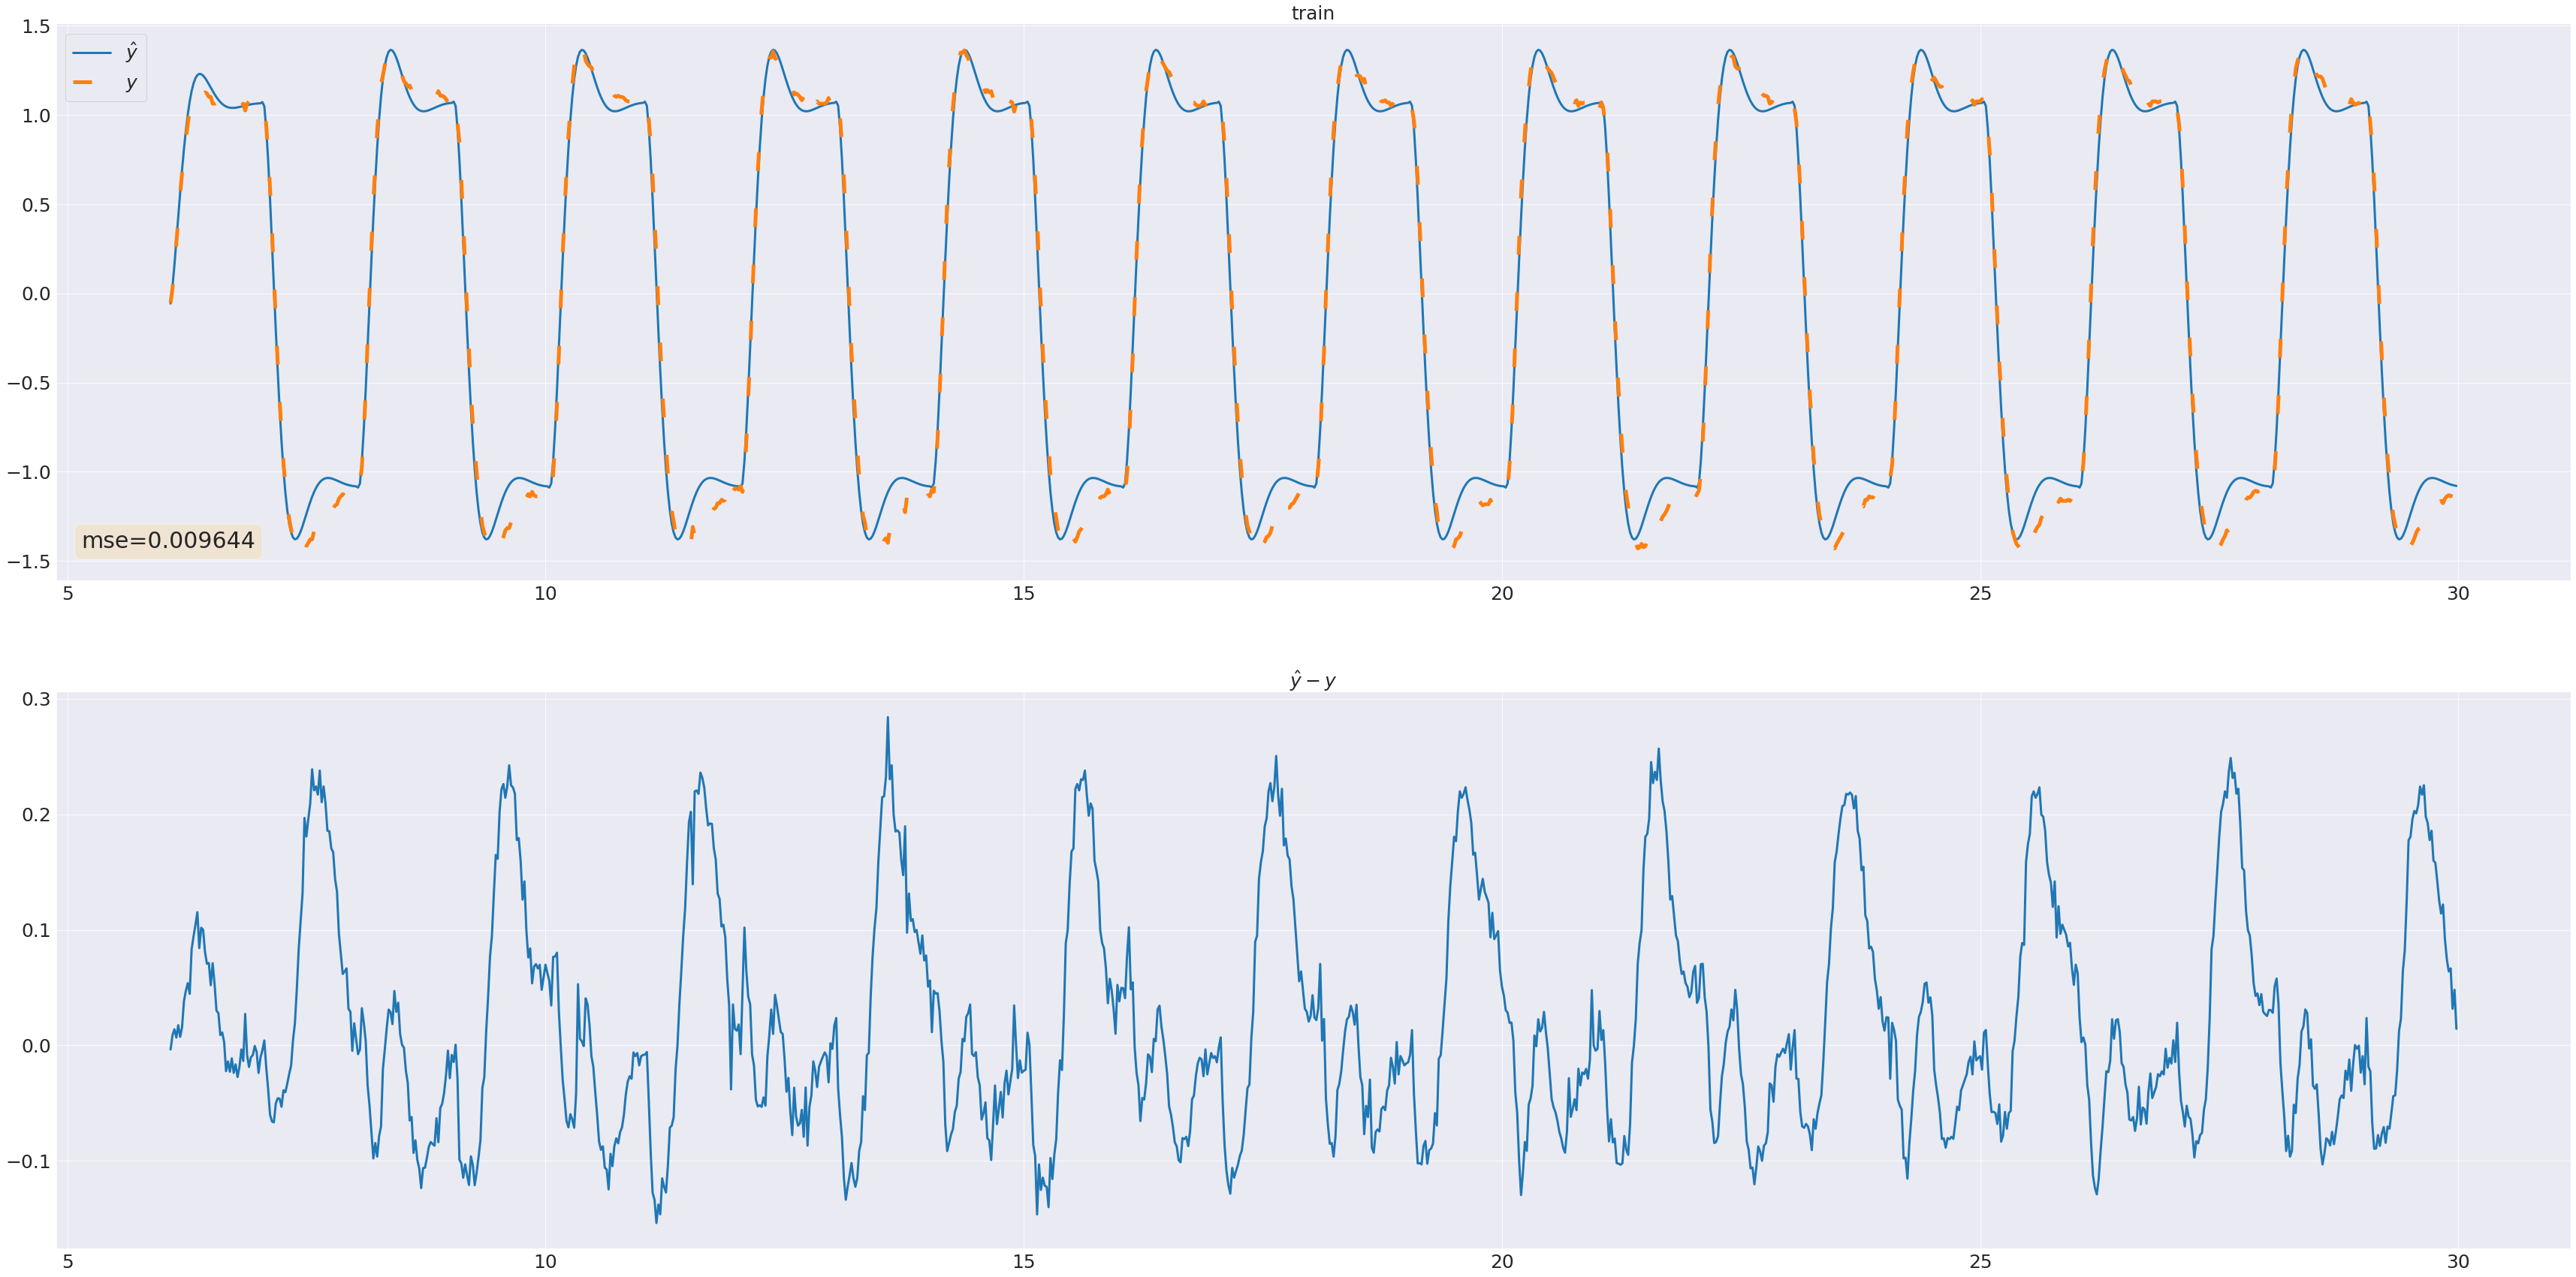

In [5]:
# simulate model on test data
df_1['x'] = simulate(theta_01, df_1[lagged_y].iloc[0, :], df_1[lagged_u])
#df_1['x'] = np.asarray(df_1[lagged_y+lagged_u]) @ theta_1

# training error
mse_train_2 = mean_squared_error(df_1['x'], df_1['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_1['time']), df_1['x'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_1['time']), np.asarray(df_1['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_2,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_1['time']), df_1['x'] - np.asarray(df_1['y']))
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

## Step 3: generate instruments with the ARX model

In [6]:
df_22 = copy.deepcopy(df_2)
df_11 = copy.deepcopy(df_1)

lagged_x = ['x_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_22['x_lag' + str(i)] = df_22['x'].shift(i)

df_22 = df_22.dropna()

# Step 4: IV estimate coefficients theta

In [7]:
# # solve with IV
# model_LS_02 = IV2SLS(dependent=df_22['x'],
#                     exog=df_22[lagged_x+lagged_u],
#                     endog=None,
#                     instruments=None)
# results_02 = model_LS_02.fit()
# #save results
# theta_02_df = results_02.params
# theta_02 = np.asarray(theta_02_df)

# sovle IV by hand
Z = np.asarray(df_22[lagged_x + lagged_u])
X = np.asarray(df_22[lagged_y + lagged_u])
y = np.asarray(df_22['y'])
theta_02 = np.linalg.inv(Z.T @ X) @ Z.T @ y

## Step 4.1 Simulate the model on train data

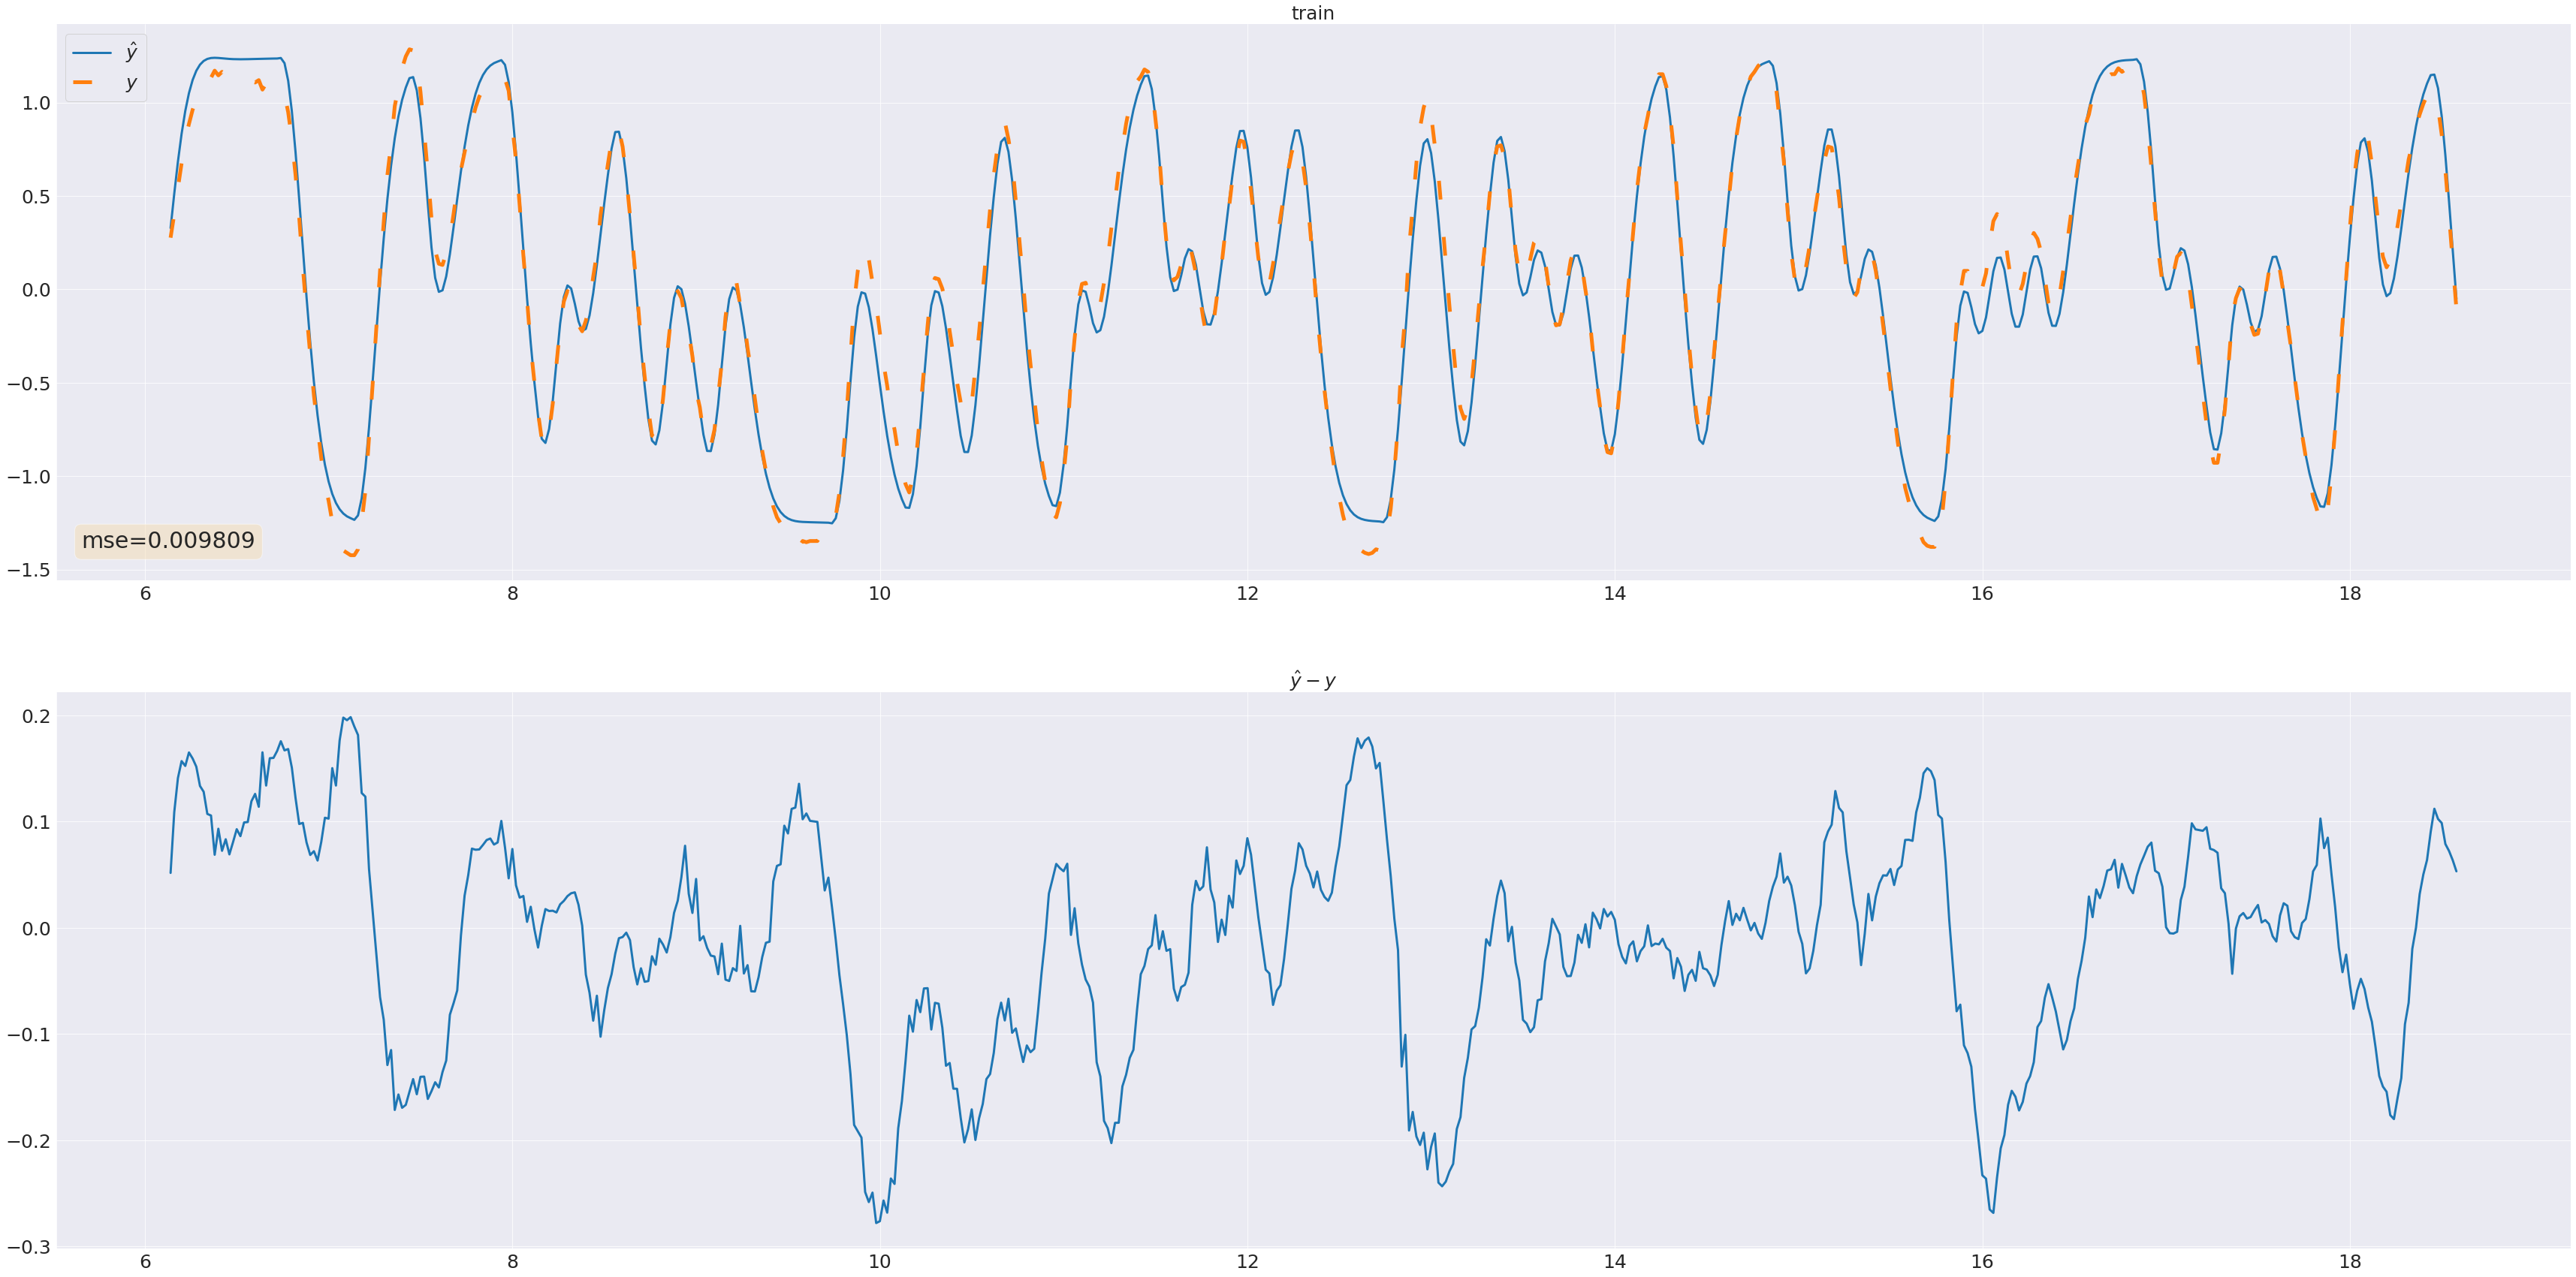

In [8]:
# simulate model on train data
df_22['z'] = simulate(theta_02, df_22[lagged_y].iloc[0, :], df_22[lagged_u])
#df_22['x'] = np.asarray(df_22[lagged_y+lagged_u]) @ theta_02 # one step pred.

# training error
mse_train_22 = mean_squared_error(df_22['z'], df_22['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_22['time']), df_22['z'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_22['time']), np.asarray(df_22['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_22,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_22['time']), df_22['z'] - df_22['y'])
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

## Step 4.2: Simulate the model on test data

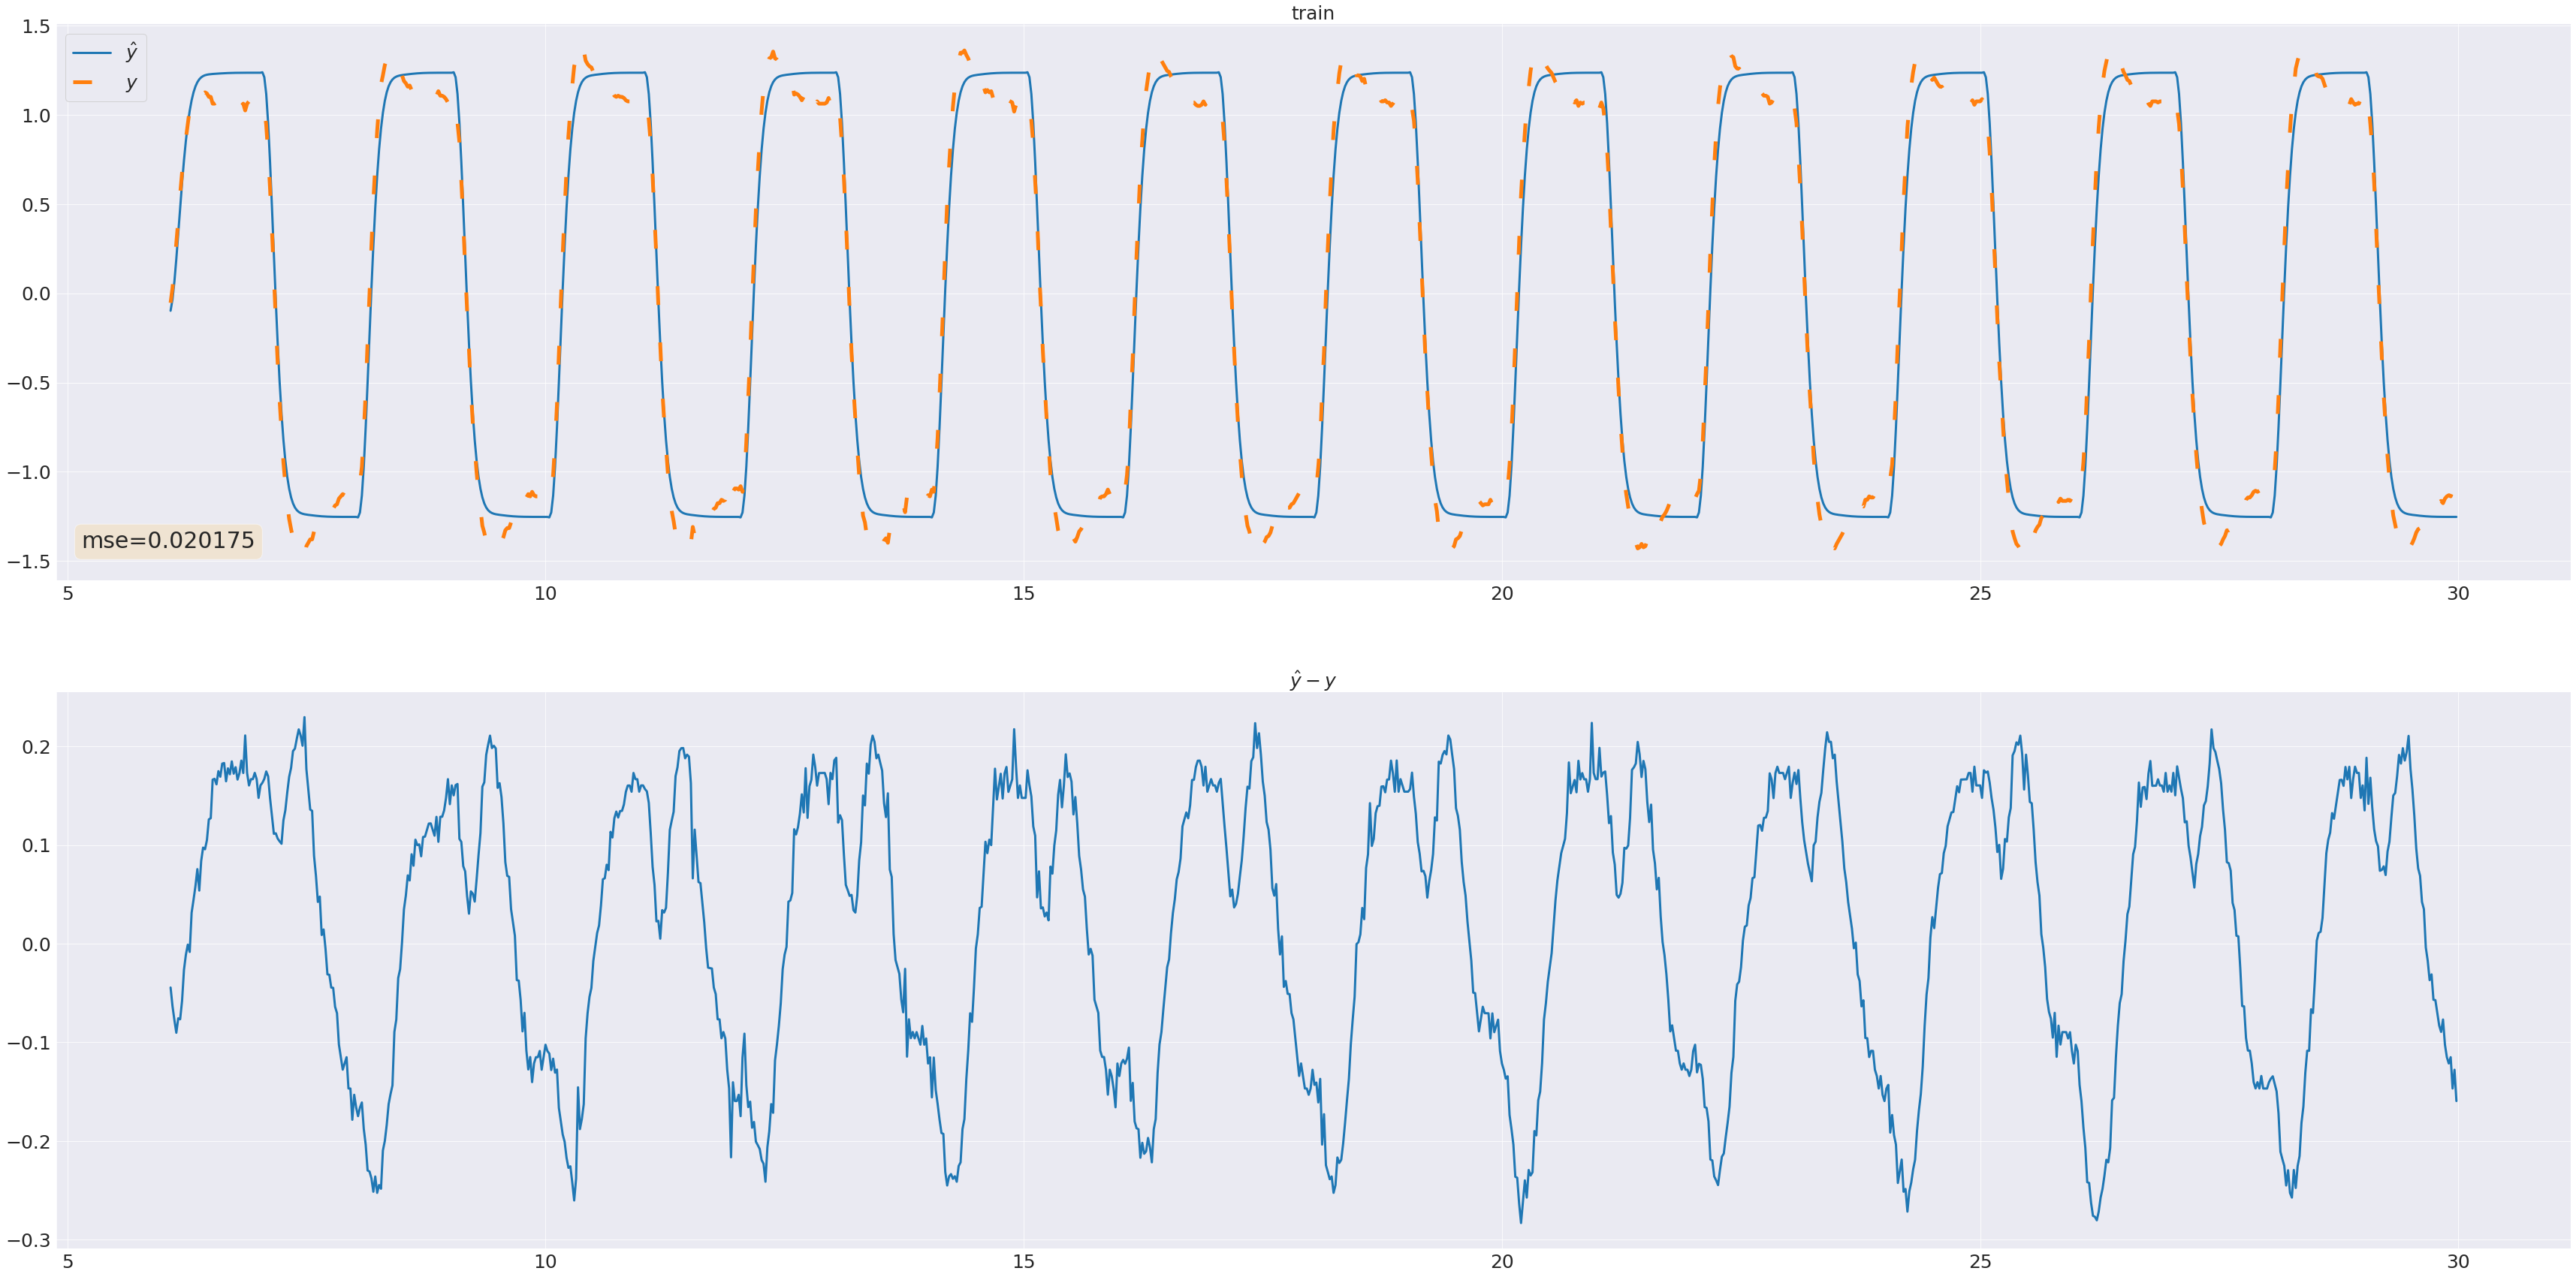

In [9]:
# simulate model on test data
df_11['z'] = simulate(theta_02, df_11[lagged_y].iloc[0, :], df_11[lagged_u])
#df_11['x'] = np.asarray(df_11[lagged_y+lagged_u]) @ theta_02

# training error
mse_train_11 = mean_squared_error(df_11['z'], df_11['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_11['time']), df_11['z'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_11['time']), np.asarray(df_11['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_11,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_11['time']), df_11['z'] - np.asarray(df_11['y']))
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)
plt.show()

## Step 4.3 Compute the residuals

[ 2.27293388e+00 -1.76380726e+00  4.67819734e-01 -1.31387498e-03
  1.68536892e-02  1.31537087e-02]


/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


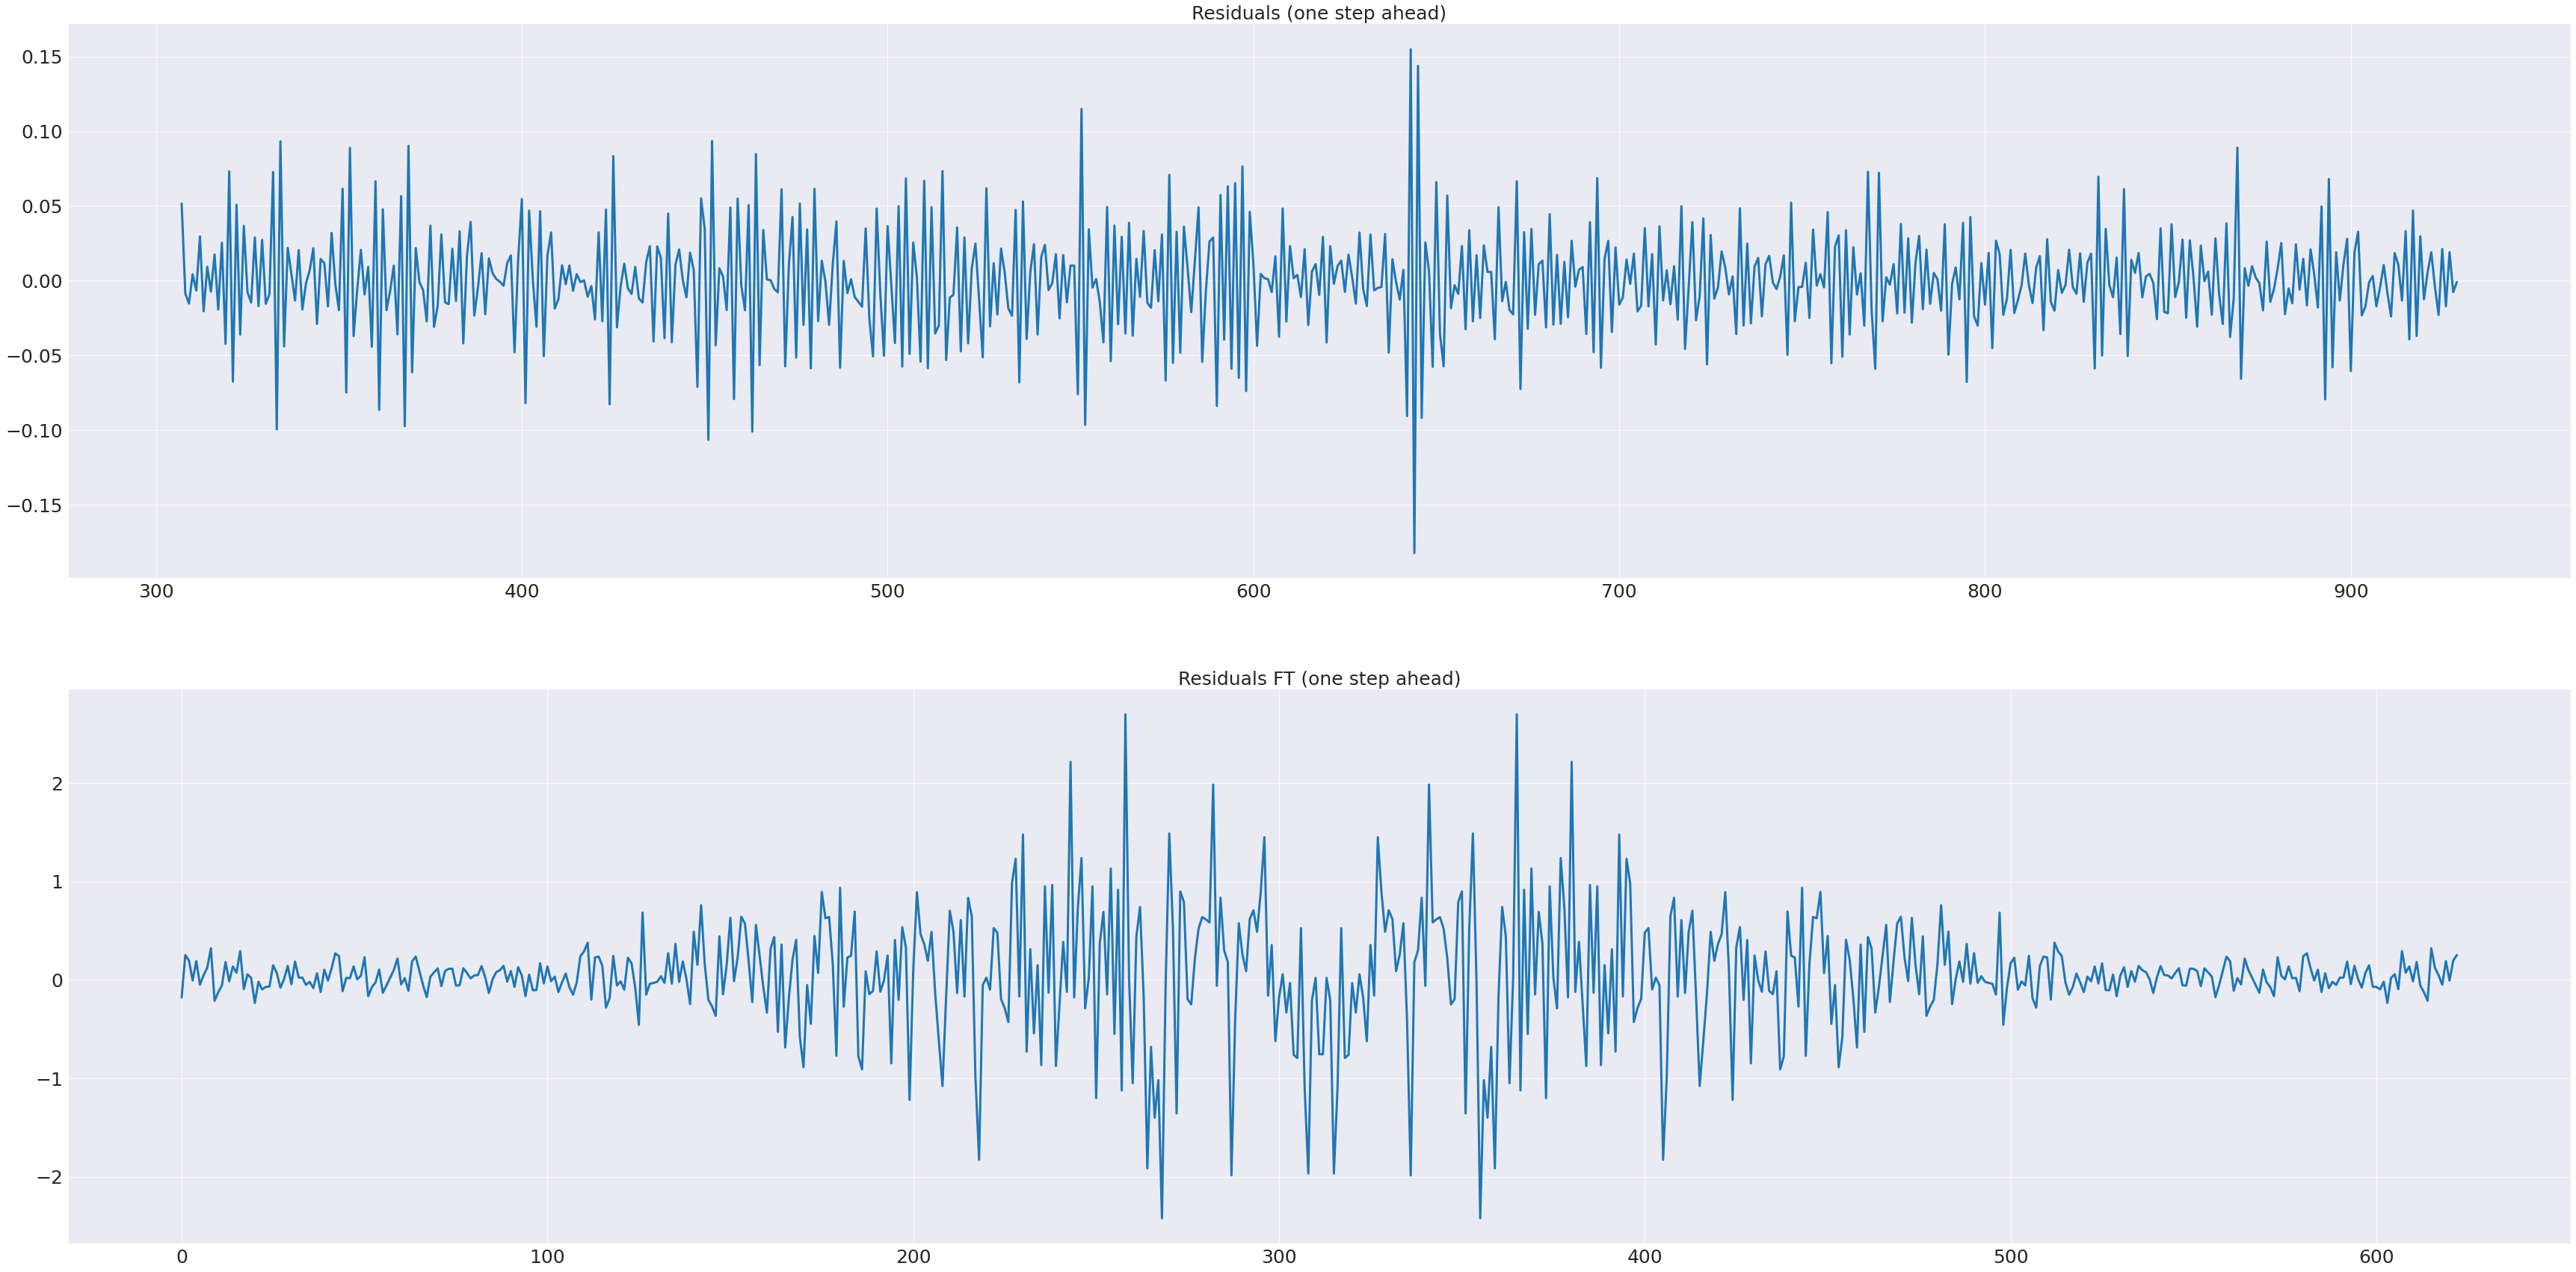

/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


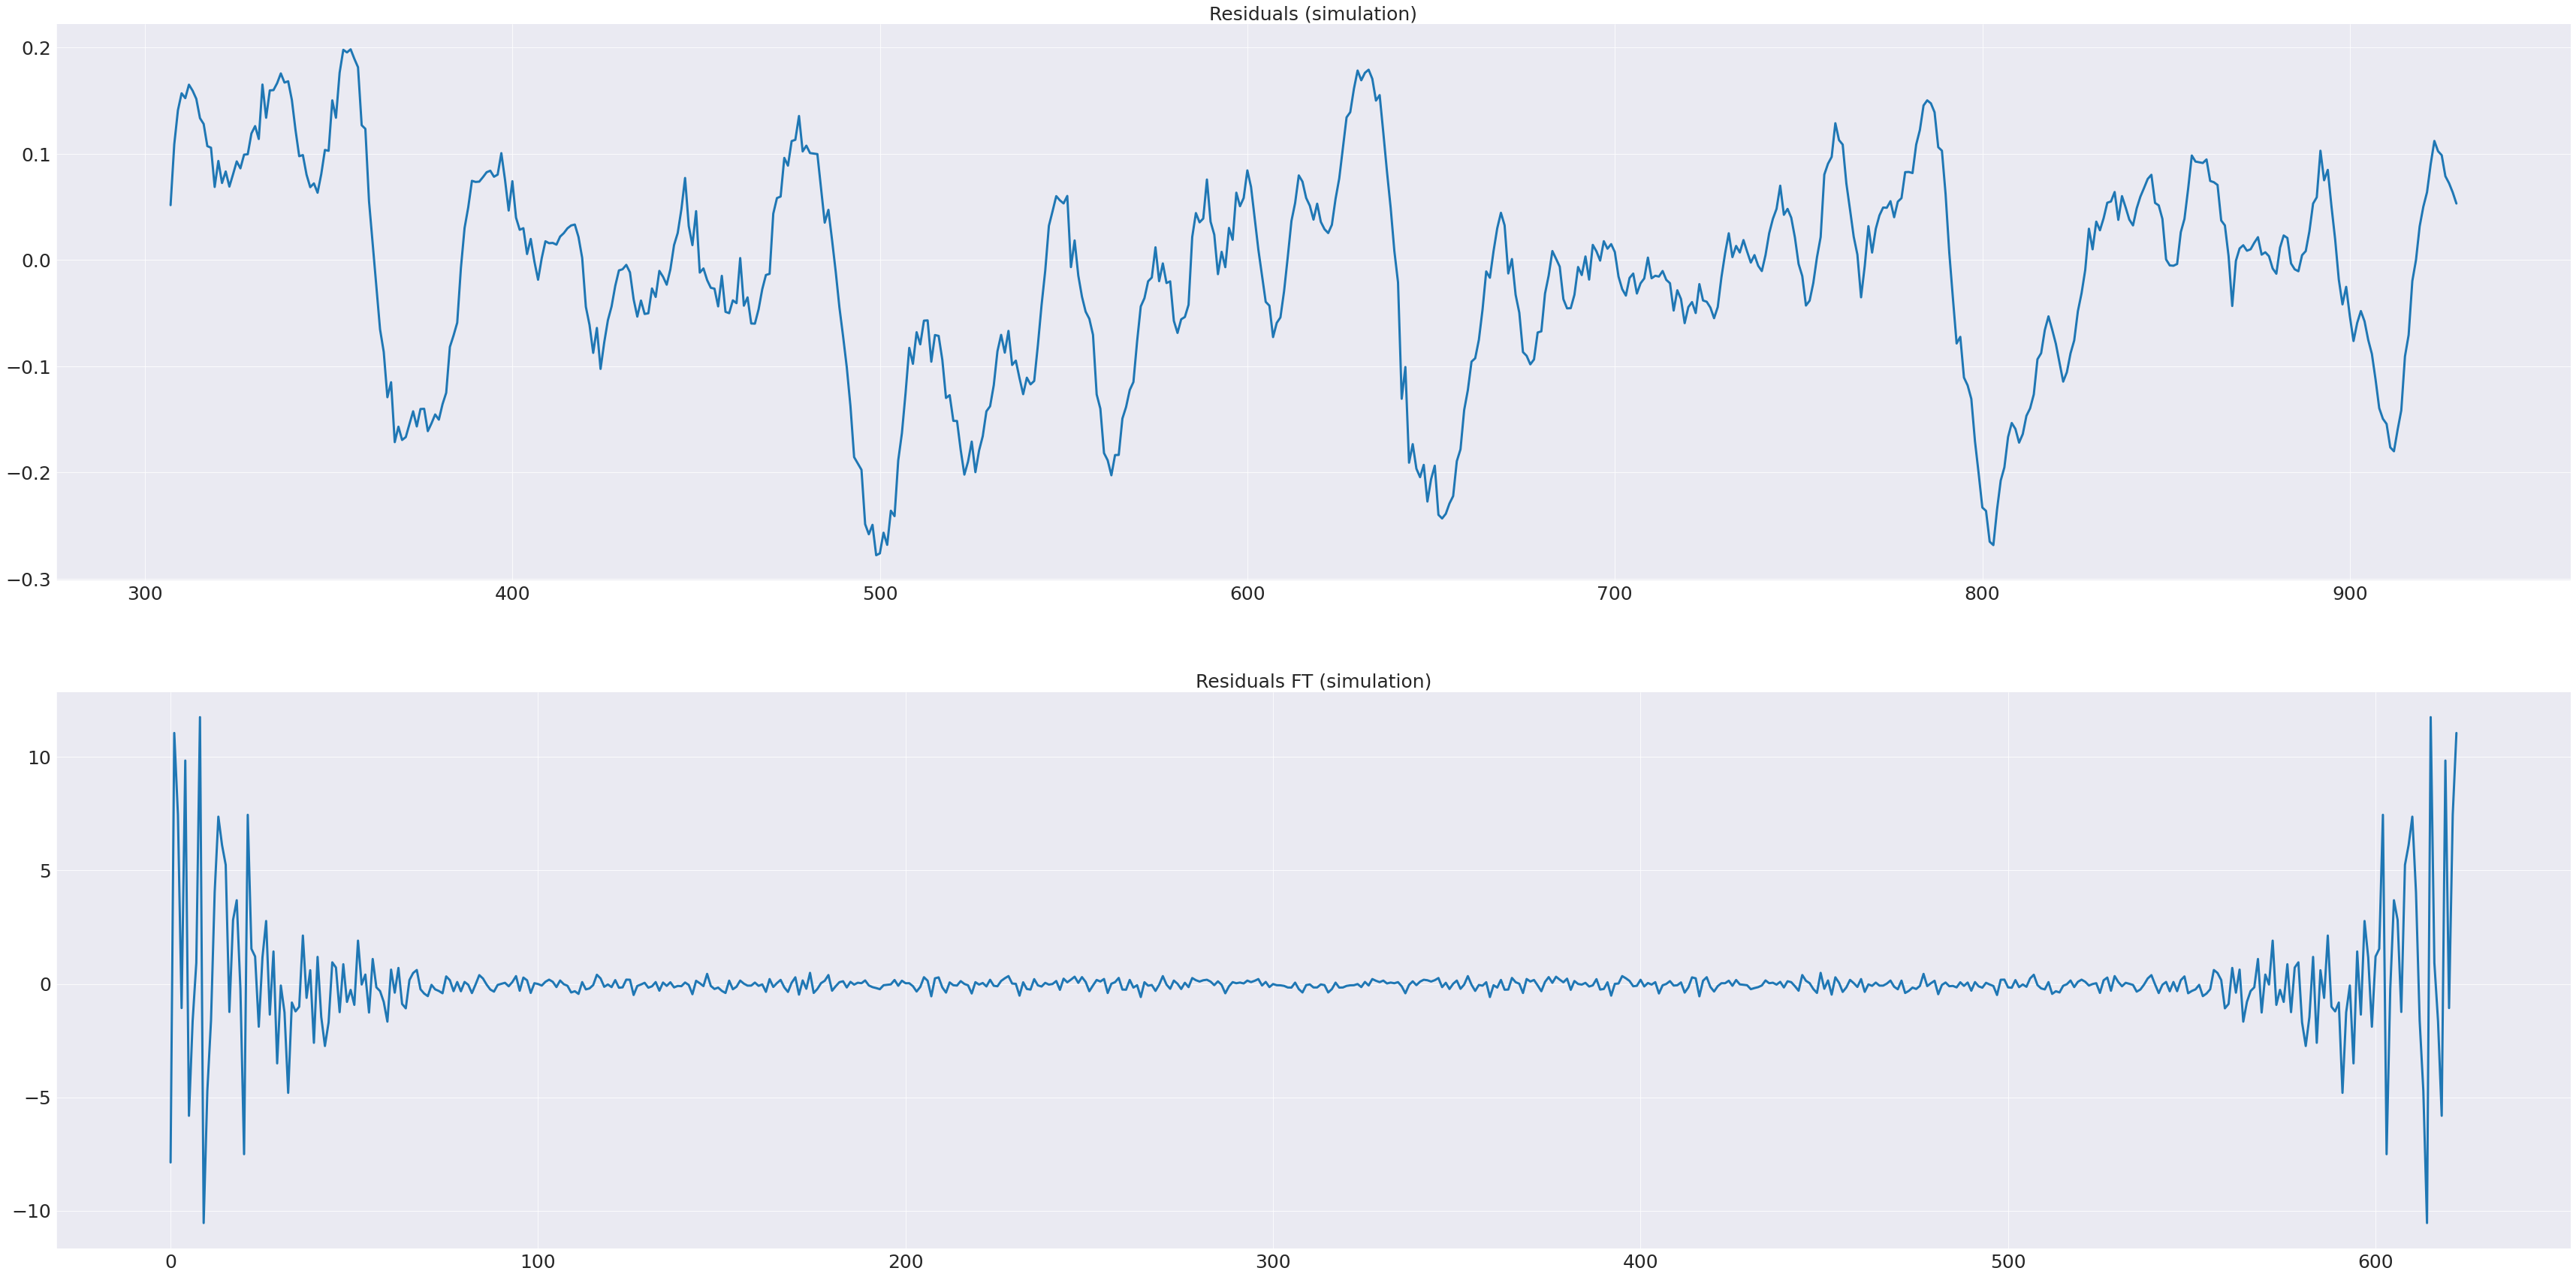

In [10]:
print(theta_02)

e_train = df_22[lagged_y] @ theta_02[:lag] + df_22[lagged_u] @ theta_02[lag:] - df_22['y']
#e_train = df_22['z'] - df_22['y']
ft_e_train = np.fft.fft(e_train)

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].grid(True)
axn[0].plot(e_train)
axn[0].set_title('Residuals (one step ahead)')
axn[1].grid(True)
axn[1].plot(ft_e_train)
axn[1].set_title('Residuals FT (one step ahead)')
plt.show()

e_train = df_22['z'] - df_22['y']
ft_e_train = np.fft.fft(e_train)

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].grid(True)
axn[0].plot(e_train)
axn[0].set_title('Residuals (simulation)')
axn[1].grid(True)
axn[1].plot(ft_e_train)
axn[1].set_title('Residuals FT (simulation)')
plt.show()

Ljung-Box test:
        lb_stat  lb_pvalue
10  3097.215652        0.0
-------------
Significant correlations at lags: [-619 -618 -617 -616 -615 -614 -613]
Pearson correlation: -0.05434543890538912, p-value: 0.1755011916166944
Spearman correlation: -0.07729421101276918, p-value: 0.05382129907842575


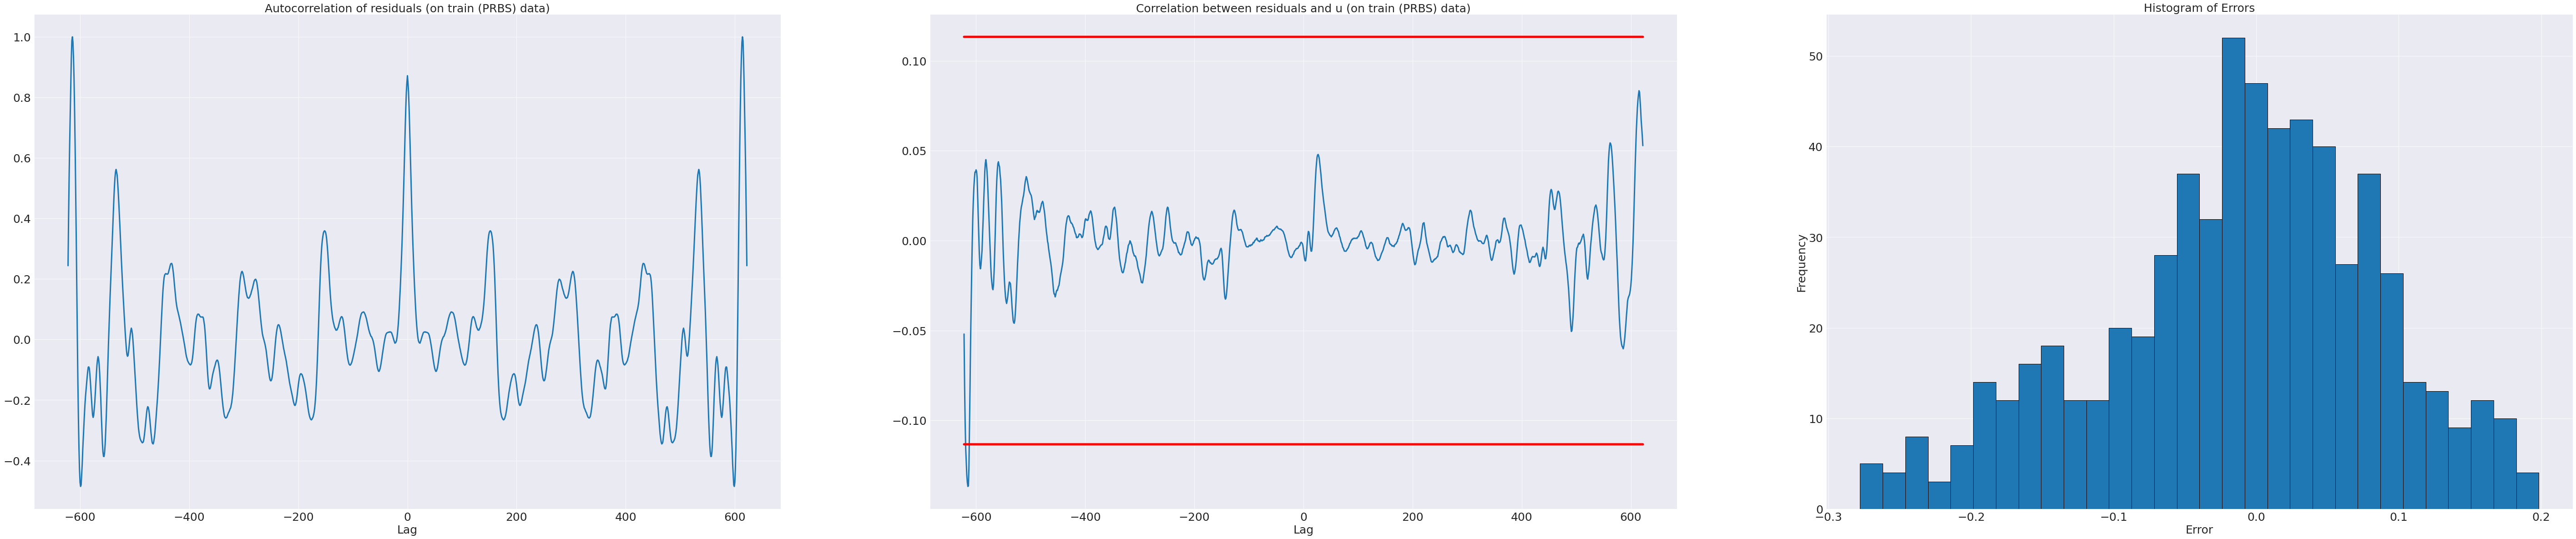

In [11]:
e_train_lags_arr = np.arange(-len(e_train) + 1, len(e_train))
u_train = df_22['u']

#------- white noise test (Ljung, pg. 512) ------------------

# R_epsilon
# R_e = []
# for i in range(l):
#     R_e.append(np.sum(1 / (l - i) * e_train[:l - i] * e_train[i:]))
R_e = sc.signal.correlate(e_train, e_train, mode='full')

# calculate the number of overlapping points at each lag
overlap_e = np.correlate(np.ones_like(e_train), np.ones_like(e_train), mode='full')

R_e = R_e / overlap_e

# perform the Ljung-Box test
ljung_box = sm.stats.diagnostic.acorr_ljungbox(e_train, lags=[10], return_df=True)
print('Ljung-Box test:')
print(ljung_box)
print('-------------')

fig, axn = plt.subplots(1,3,figsize=(100,20))
axn[0].plot(e_train_lags_arr,R_e/max(R_e))
axn[0].set_title('Autocorrelation of residuals (on train (PRBS) data)')
axn[0].set_xlabel('Lag')
axn[0].grid(True)

#------- u, e independence test --------------

# R_epsilon,u
R_eu = scipy.signal.correlate(e_train, u_train, mode='full')

# calculate the number of overlapping points at each lag
overlap_eu = np.correlate(np.ones_like(e_train), np.ones_like(u_train), mode='full')

R_eu = R_eu / overlap_eu # to normalize

# remove lag zero
zero_lag_index = np.where(e_train_lags_arr == 0)[0][0]
R_eu = np.delete(R_eu, zero_lag_index)
lags = np.delete(e_train_lags_arr, zero_lag_index)

# Check the statistical significance of the correlations
# If all correlations are zero, then `a` and `b` are statistically independent
stat_sig = 2 / np.sqrt(len(e_train)/2)
significant_correlations = np.where(np.abs(R_eu) > stat_sig)
print("Significant correlations at lags:", lags[significant_correlations])

# pearson
corr, p_value = sc.stats.pearsonr(e_train, u_train)
print(f'Pearson correlation: {corr}, p-value: {p_value}')

# spearman
corr, p_value = scipy.stats.spearmanr(e_train, u_train)
print(f'Spearman correlation: {corr}, p-value: {p_value}')

# # mutal information
# mi = mutual_info_score(e_train, u_train)
# print(f'Mutual information: {mi}')

axn[1].plot(lags,R_eu)
axn[1].plot(lags, [stat_sig for i in range(len(lags))], lw=5, c='r')
axn[1].plot(lags, [-stat_sig for i in range(len(lags))], lw=5, c='r')
axn[1].set_title('Correlation between residuals and u (on train (PRBS) data)')
axn[1].set_xlabel('Lag')
axn[1].grid(True)

# Plot the histogram
axn[2].hist(e_train, bins=30, edgecolor='k')
axn[2].set_title('Histogram of Errors')
axn[2].set_xlabel('Error')
axn[2].set_ylabel('Frequency')
axn[2].grid(True)
plt.show()

### The results are comparable to the ARX model

# The Bode plot

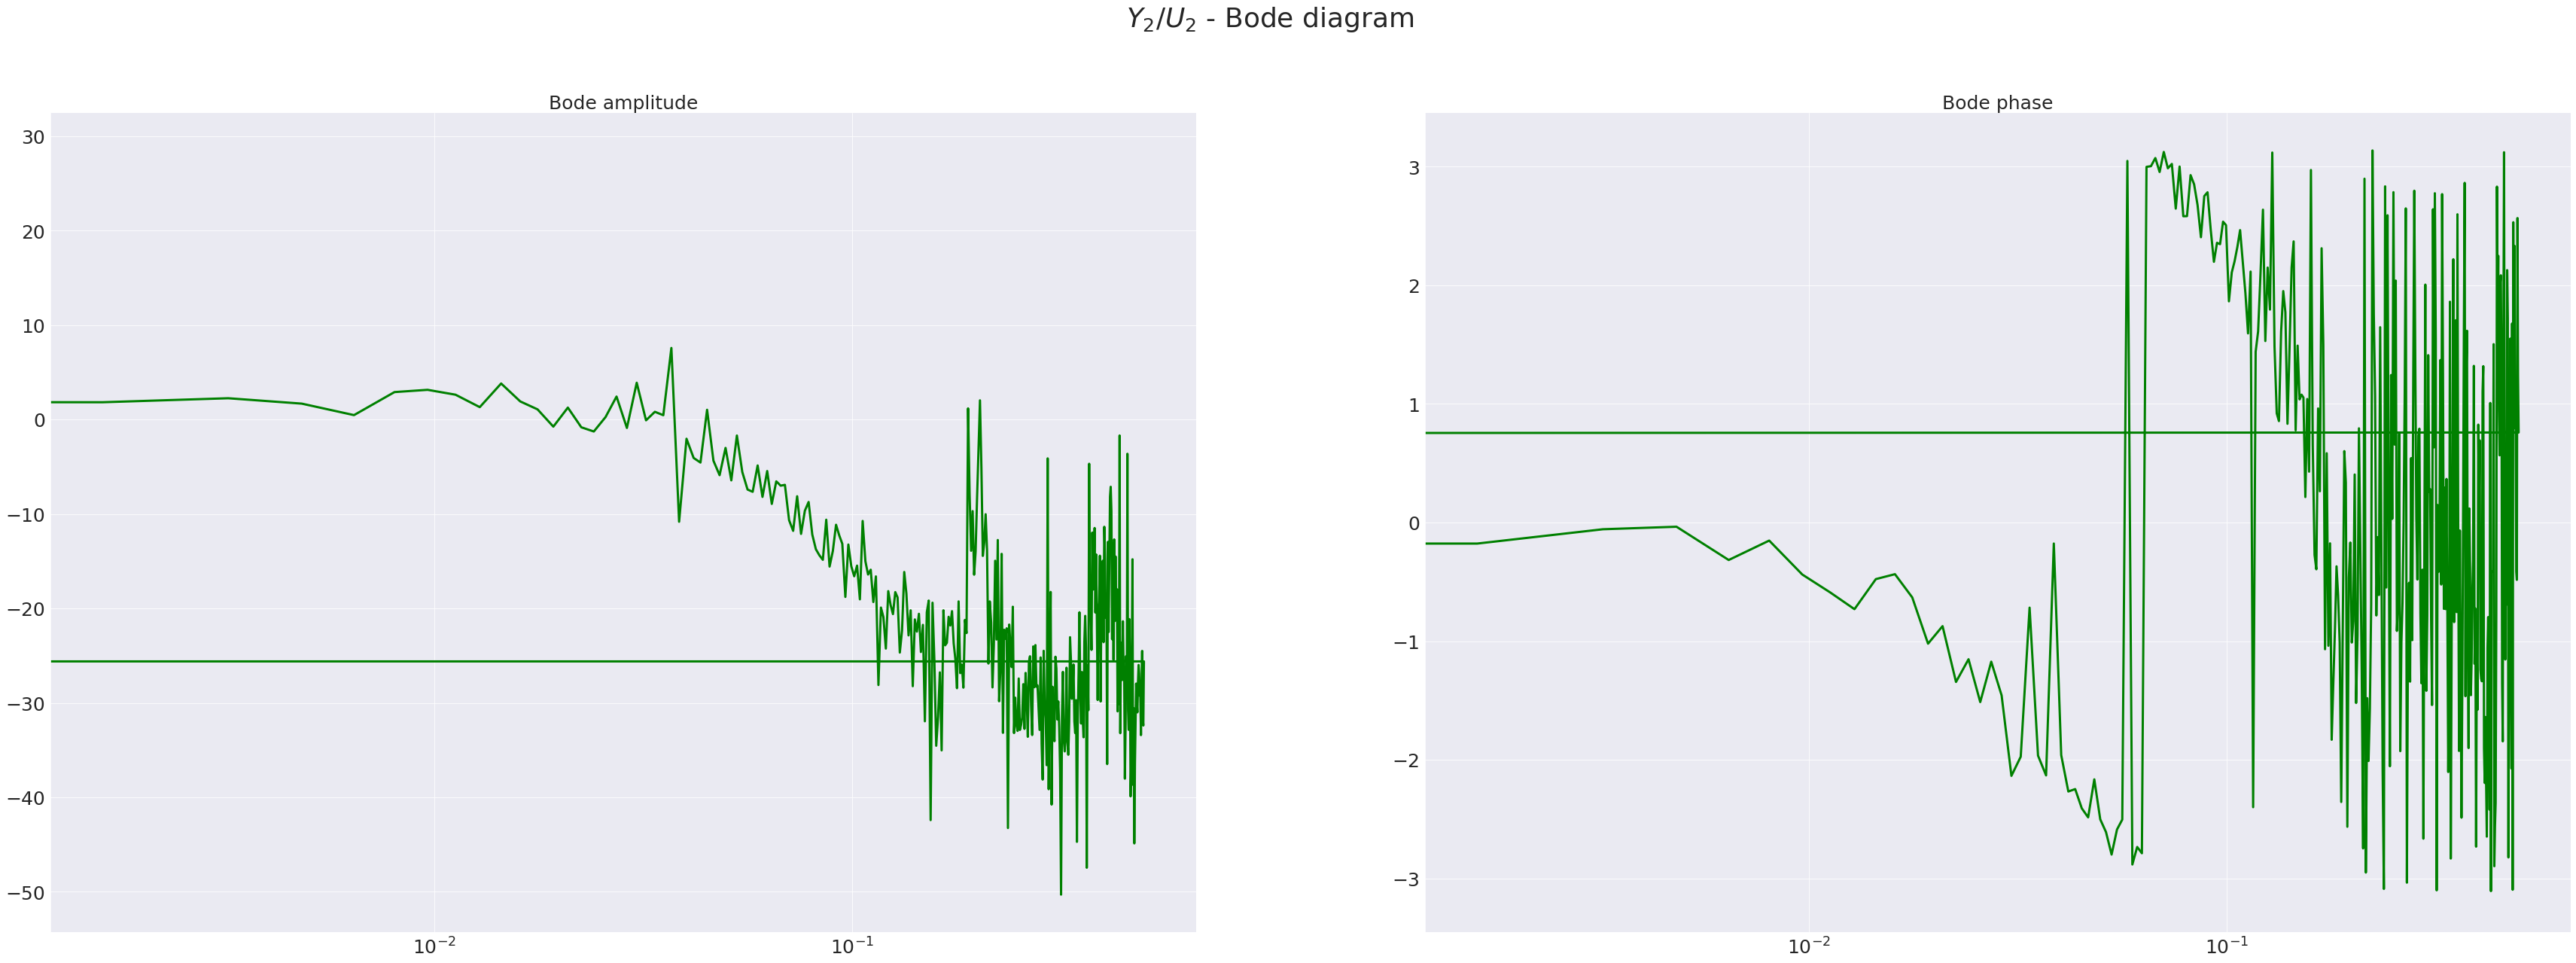

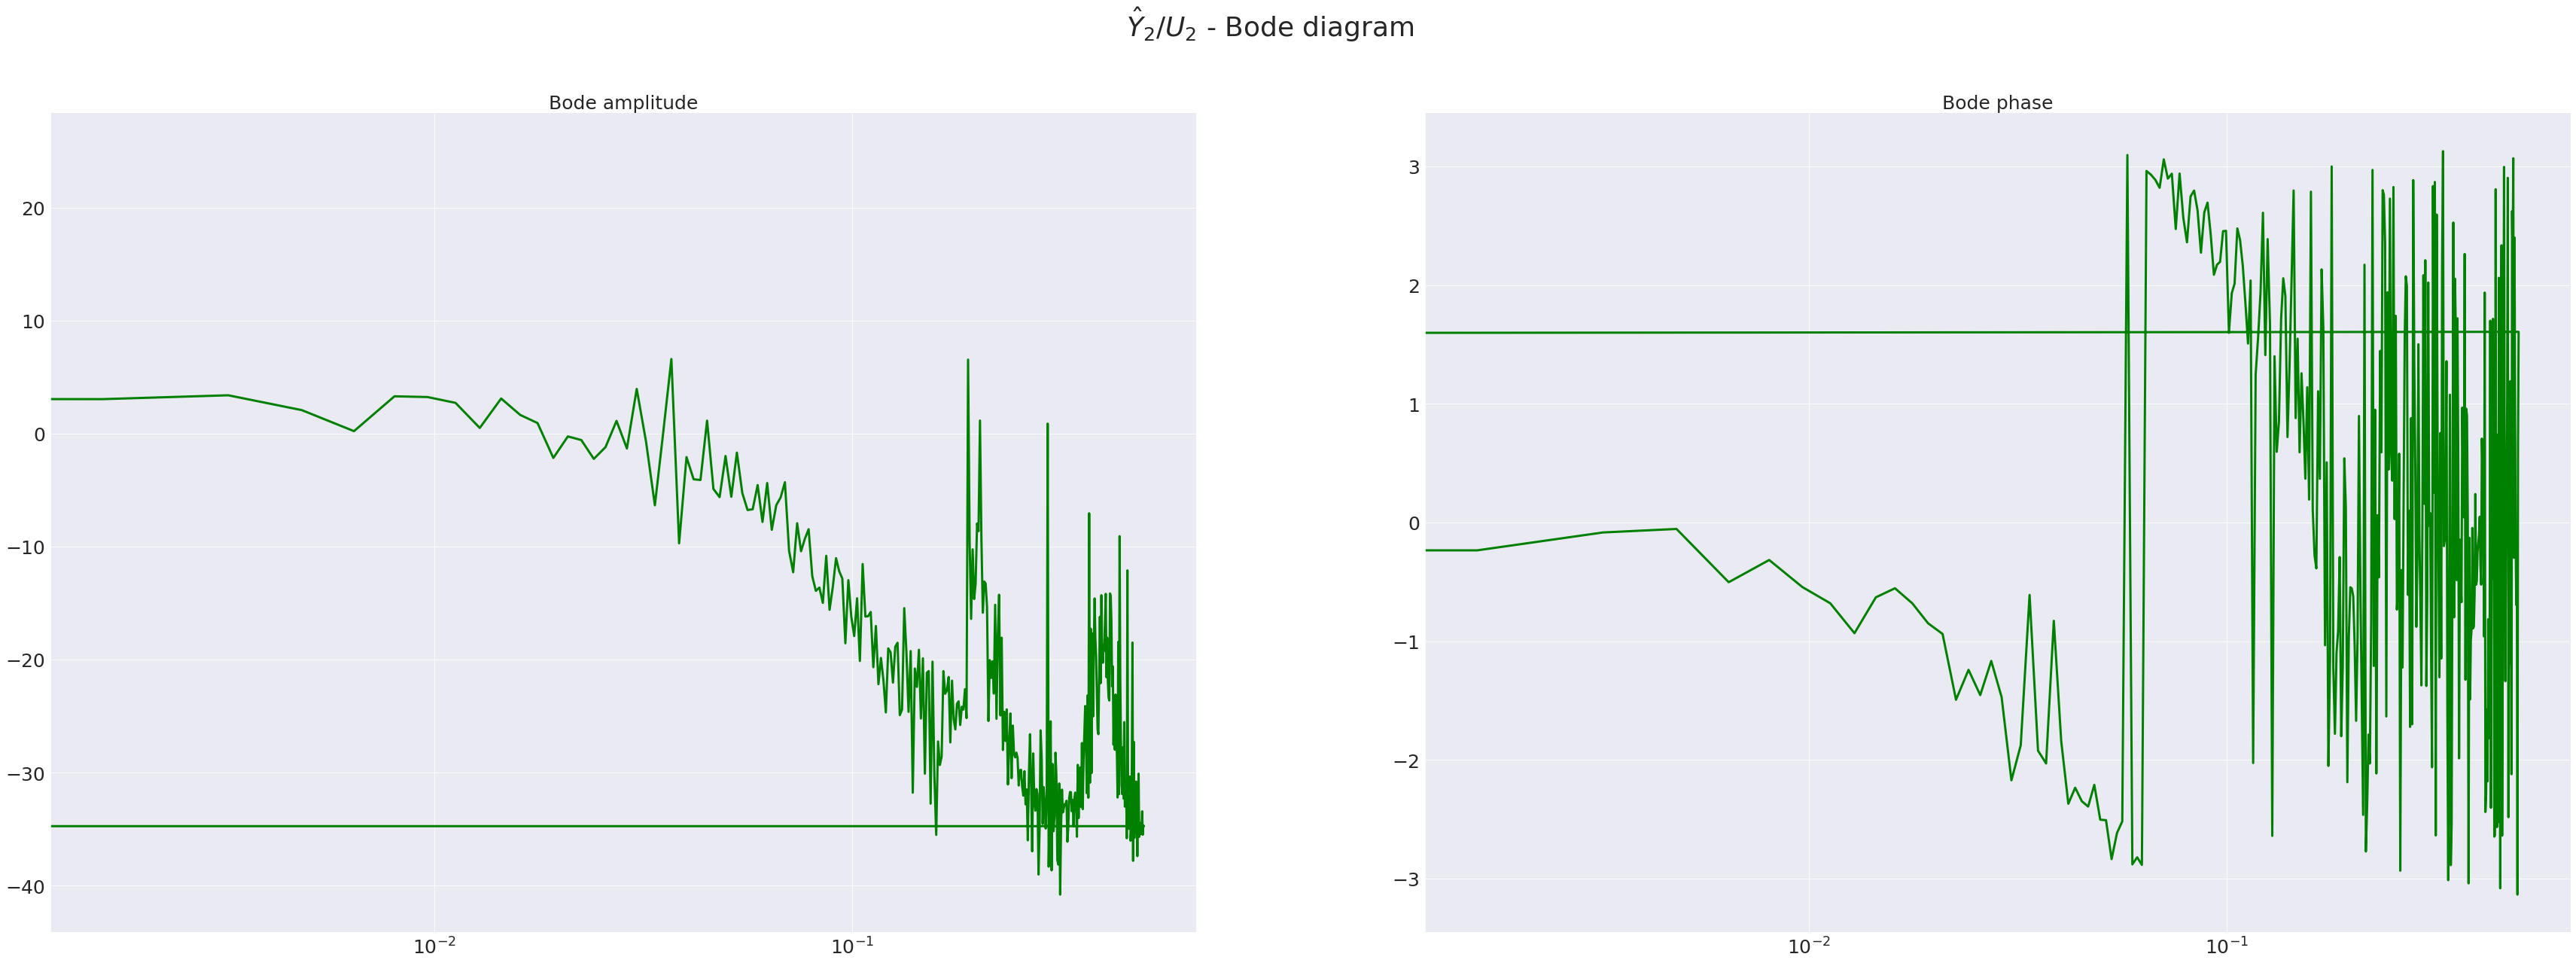

In [12]:
u_train = np.asarray(df_22['u']).reshape(-1)
y_train = np.asarray(df_22['y']).reshape(-1)
yhat_train = np.asarray(df_22['z']).reshape(-1)

fs = 1 # define sampling frequency to be 1

freqs = np.fft.fftfreq(len(u_train), 1)
ft_u = np.fft.fft(u_train)
ft_y = np.fft.fft(y_train)


fig, axn = plt.subplots(1,2,figsize=(60,20))
fig.suptitle(r'$Y_2/U_2$ - Bode diagram')
ft_G = ft_y / ft_u
axn[0].semilogx(freqs, 20 * np.log10(np.abs(ft_G)), c='g')
axn[1].semilogx(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[0].grid(True)
axn[1].grid(True)
plt.show()

freqs = np.fft.fftfreq(len(u_train), 1)
ft_u = np.fft.fft(u_train)
ft_yhat = np.fft.fft(yhat_train)

fig, axn = plt.subplots(1,2,figsize=(60,20))
fig.suptitle(r'$\hat{Y}_2/U_2$ - Bode diagram')
ft_G = ft_yhat / ft_u
axn[0].semilogx(freqs, 20 * np.log10(np.abs(ft_G)), c='g')
axn[1].semilogx(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[0].grid(True)
axn[1].grid(True)
plt.show()

# Does another iteration of IV produces a better result?

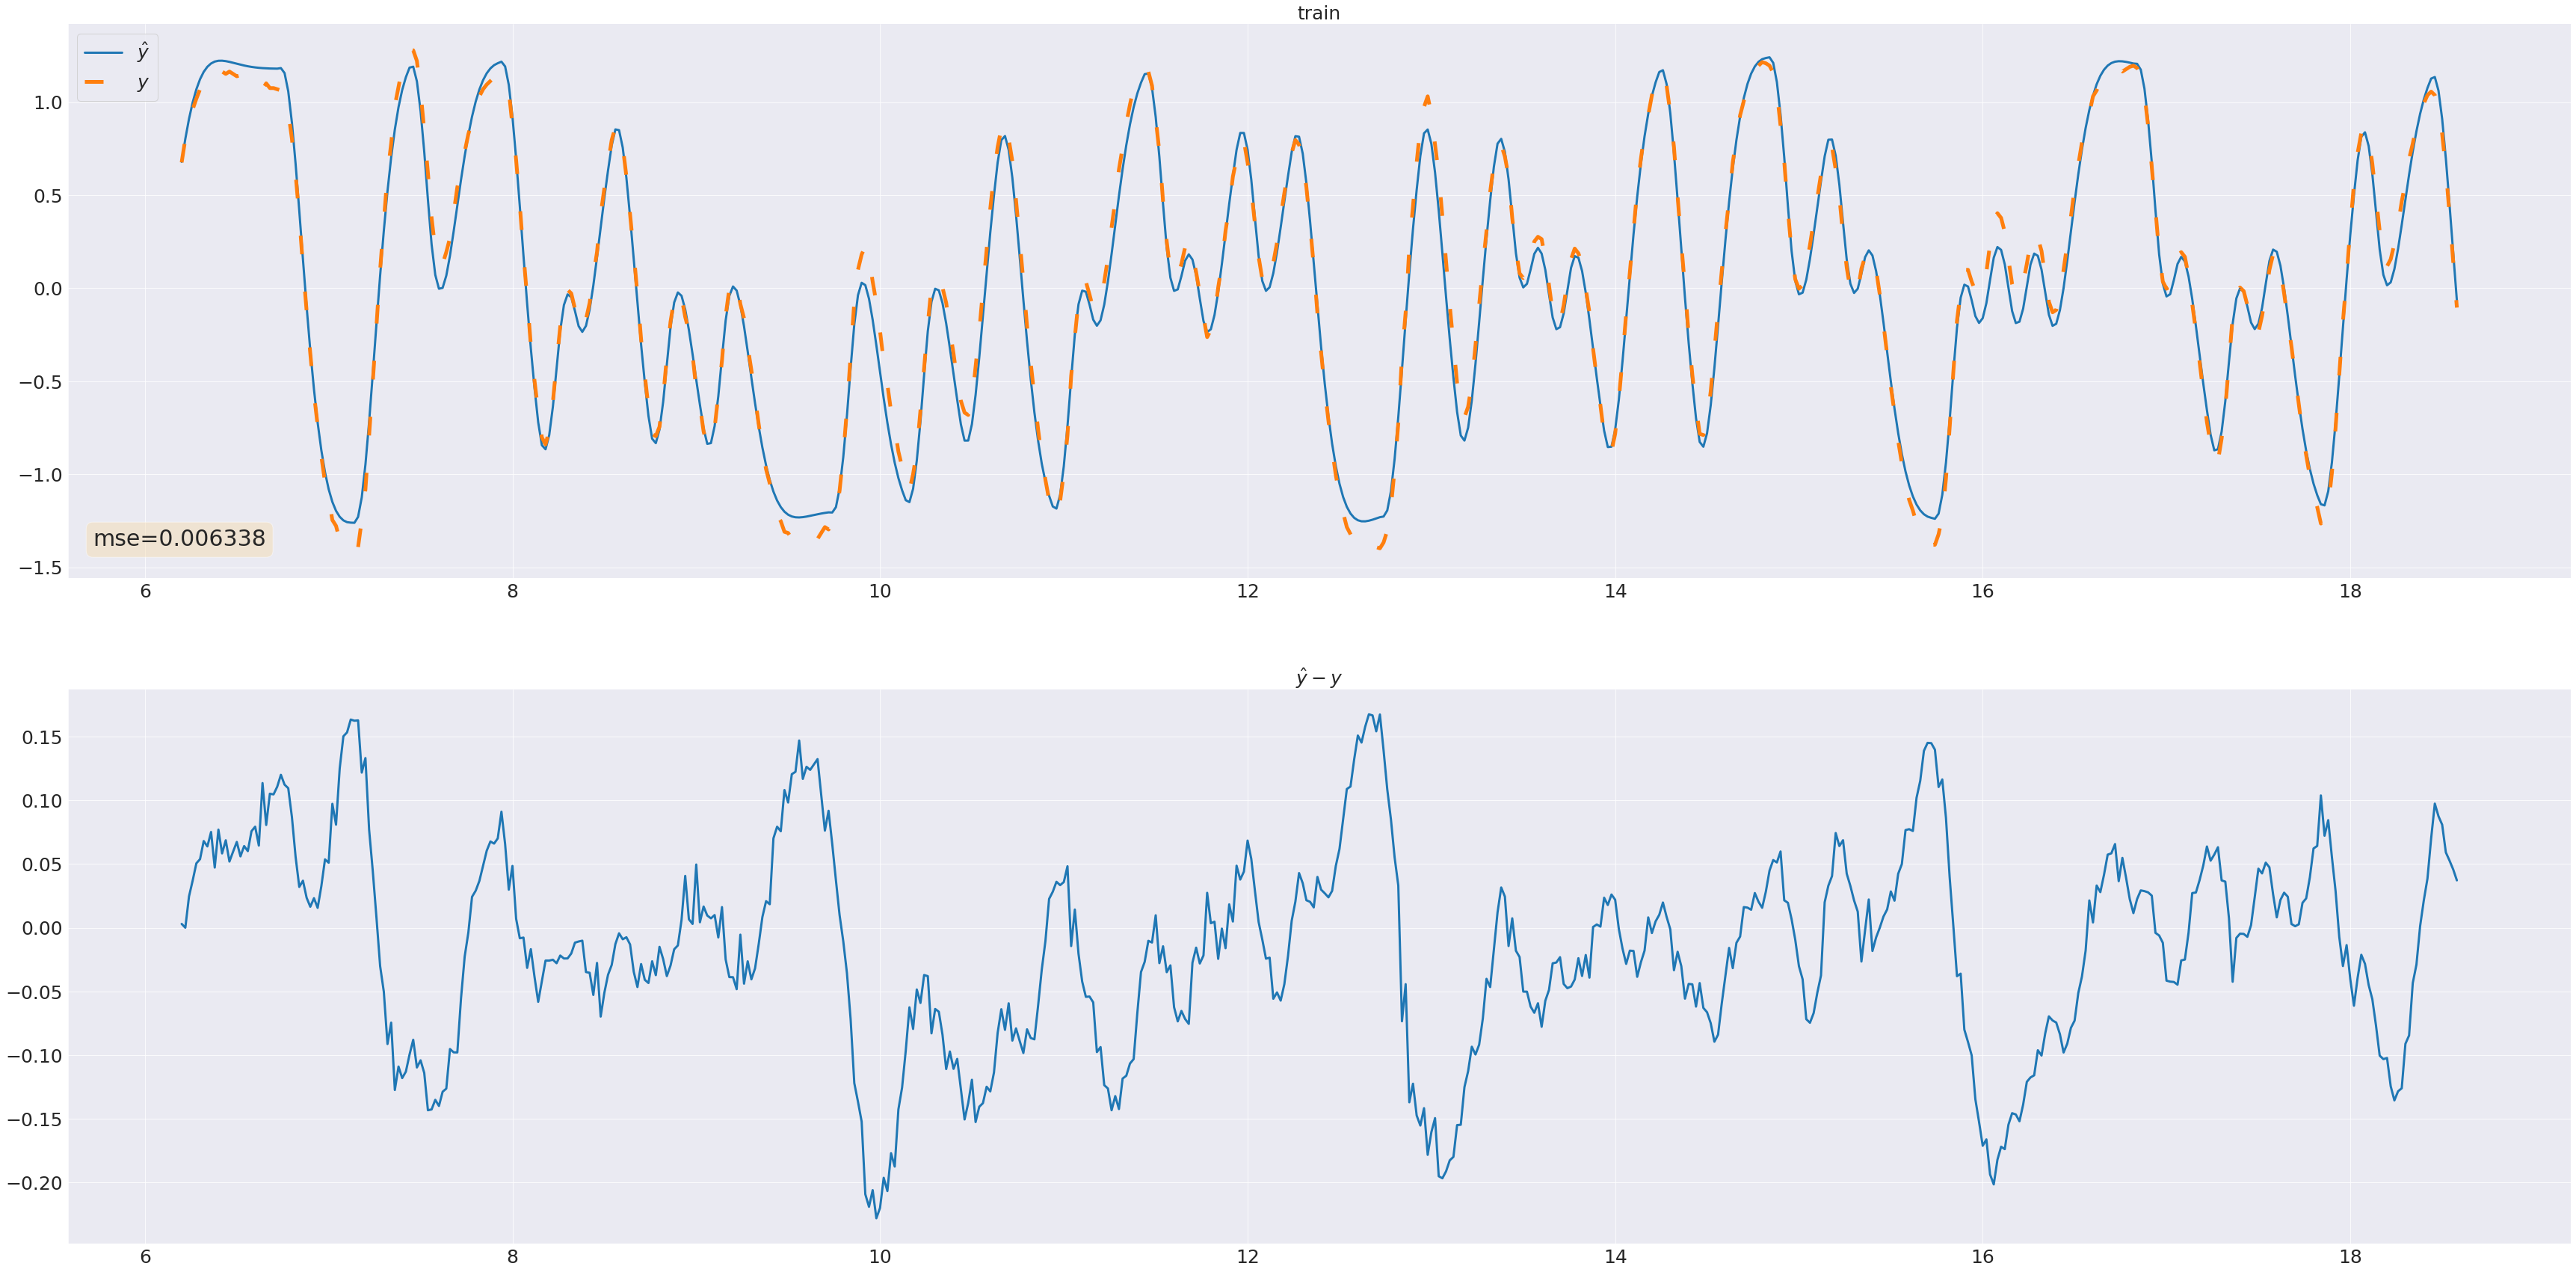

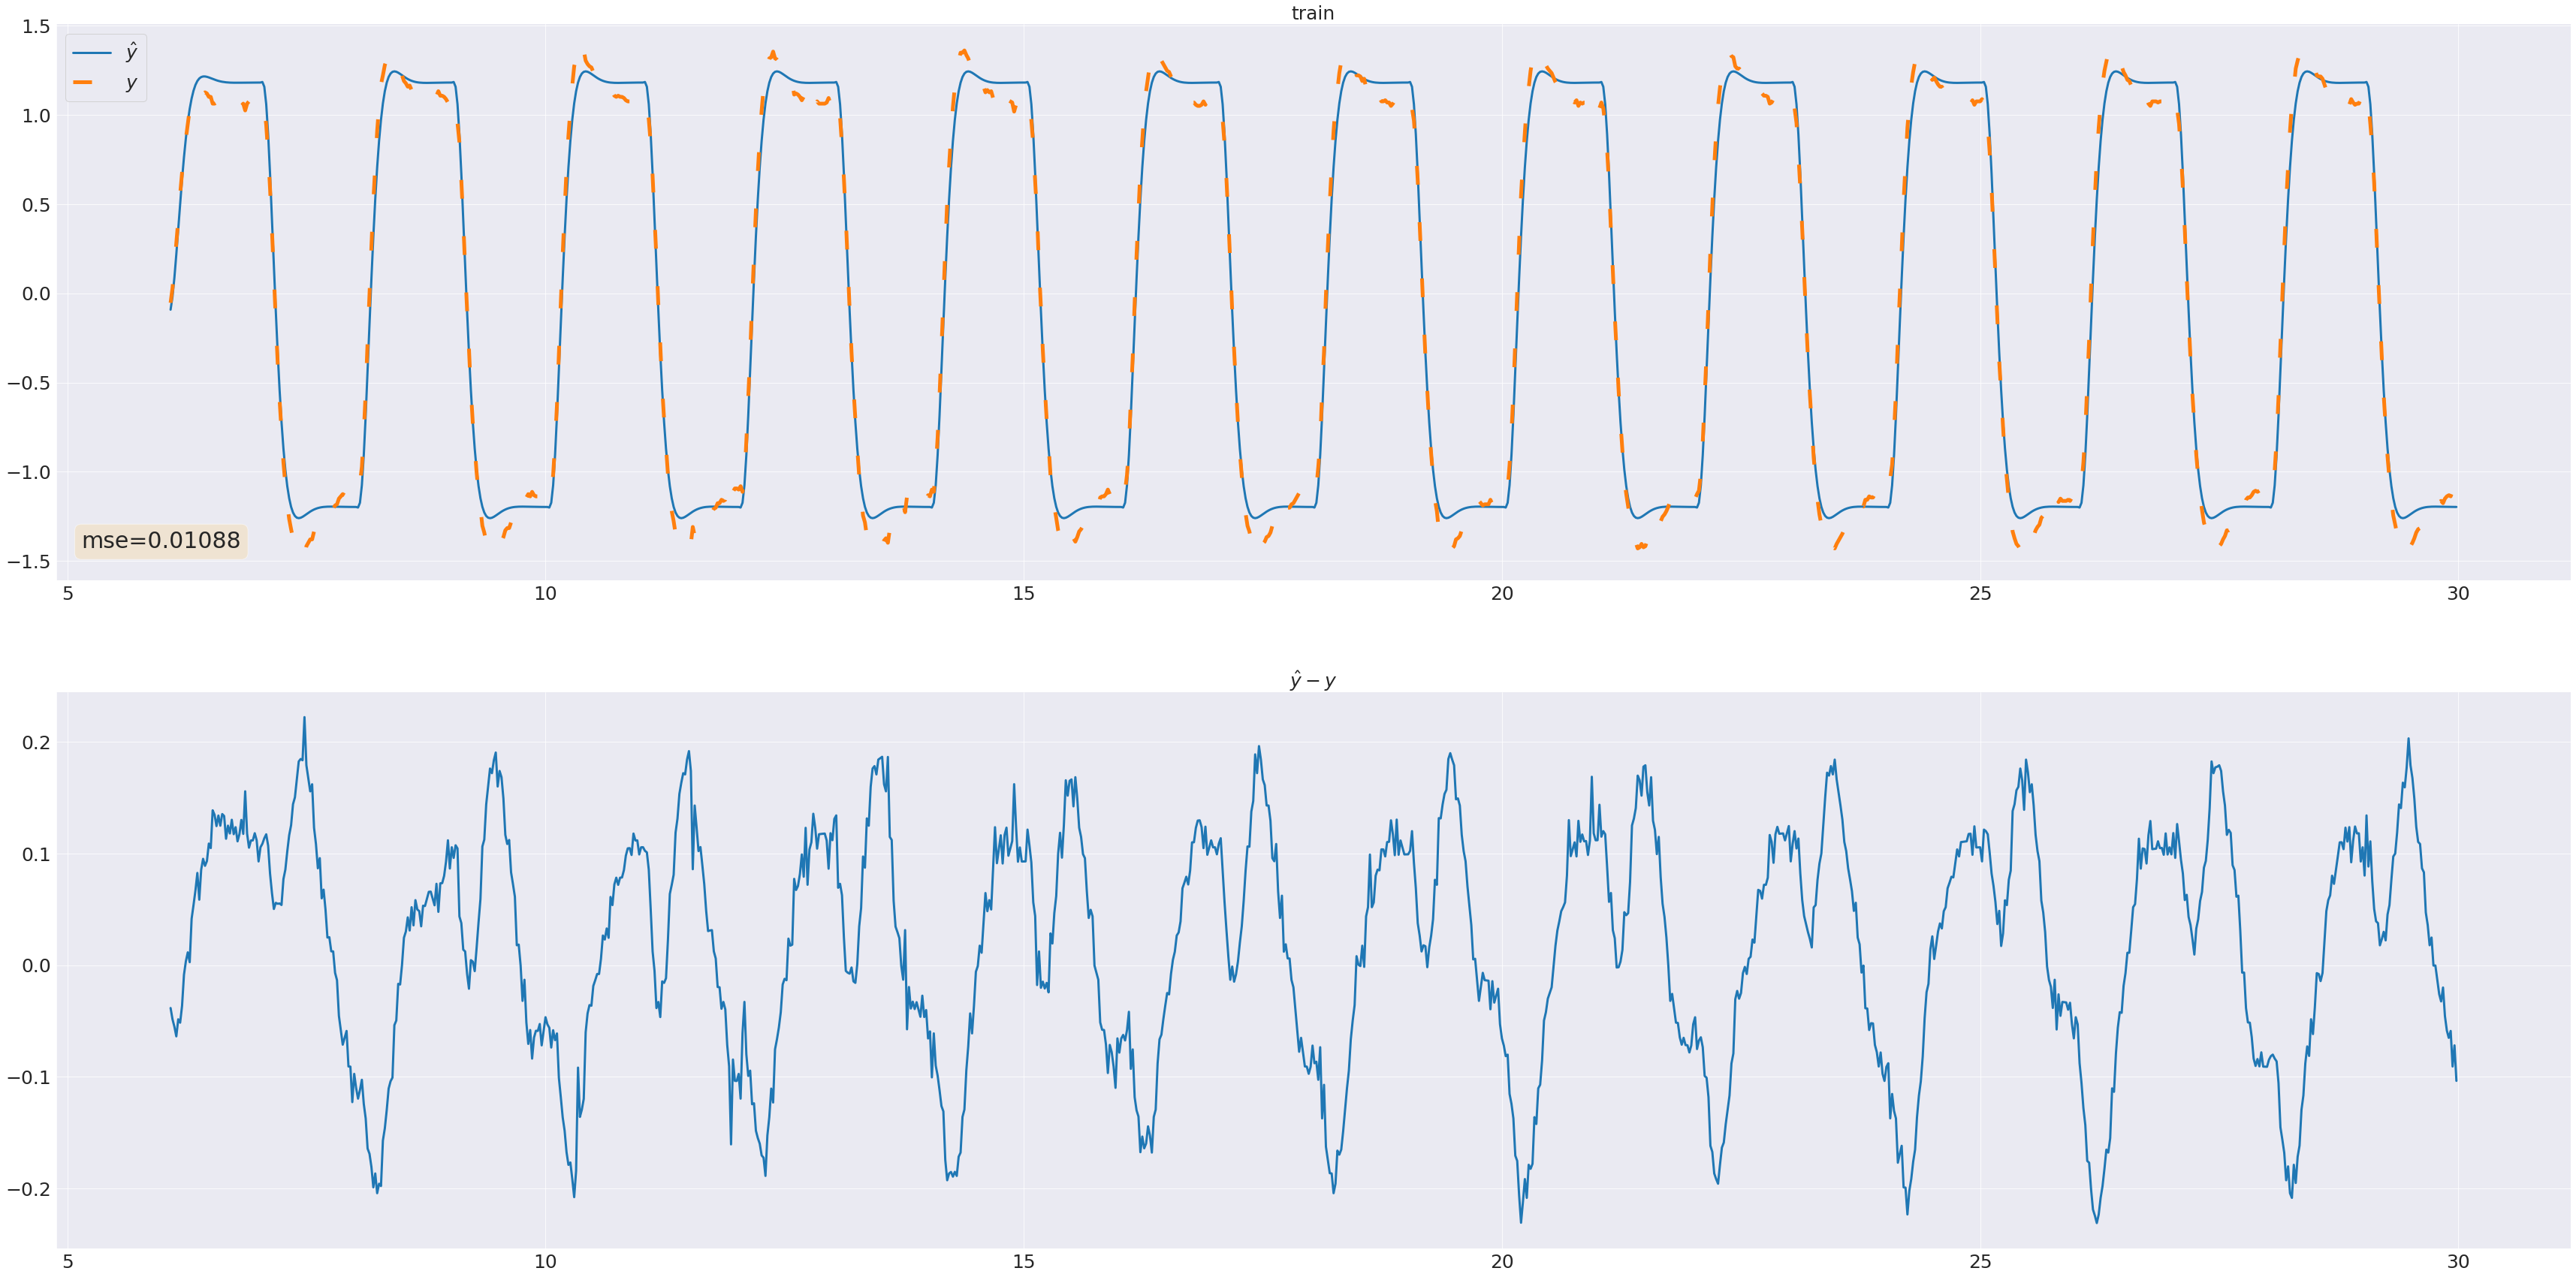

In [13]:
df_222 = copy.deepcopy(df_22)
df_111 = copy.deepcopy(df_11)

lagged_z = ['z_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_222['z_lag' + str(i)] = df_222['z'].shift(i)

df_222 = df_222.dropna()

# sovle IV by hand
Z = np.asarray(df_222[lagged_z + lagged_u])
X = np.asarray(df_222[lagged_y + lagged_u])
y = np.asarray(df_222['y'])
theta_03 = np.linalg.inv(Z.T @ X) @ Z.T @ y

# simulate model on train data
df_222['z_'] = simulate(theta_03, df_222[lagged_y].iloc[0, :], df_222[lagged_u])

# training error
mse_train_222 = mean_squared_error(df_222['z_'], df_222['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_222['time']), df_222['z_'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_222['time']), np.asarray(df_222['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_222,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_222['time']), df_222['z_'] - df_222['y'])
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

# simulate model on test data
df_111['z_'] = simulate(theta_03, df_111[lagged_y].iloc[0, :], df_111[lagged_u])
#df_11['x'] = np.asarray(df_11[lagged_y+lagged_u]) @ theta_02

# training error
mse_train_111 = mean_squared_error(df_111['z_'], df_111['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_111['time']), df_111['z_'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_111['time']), np.asarray(df_111['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_111,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_111['time']), df_111['z_'] - np.asarray(df_111['y']))
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)
plt.show()

# Yes, it does! How about another iteration? (usually only a few iterations necessary)

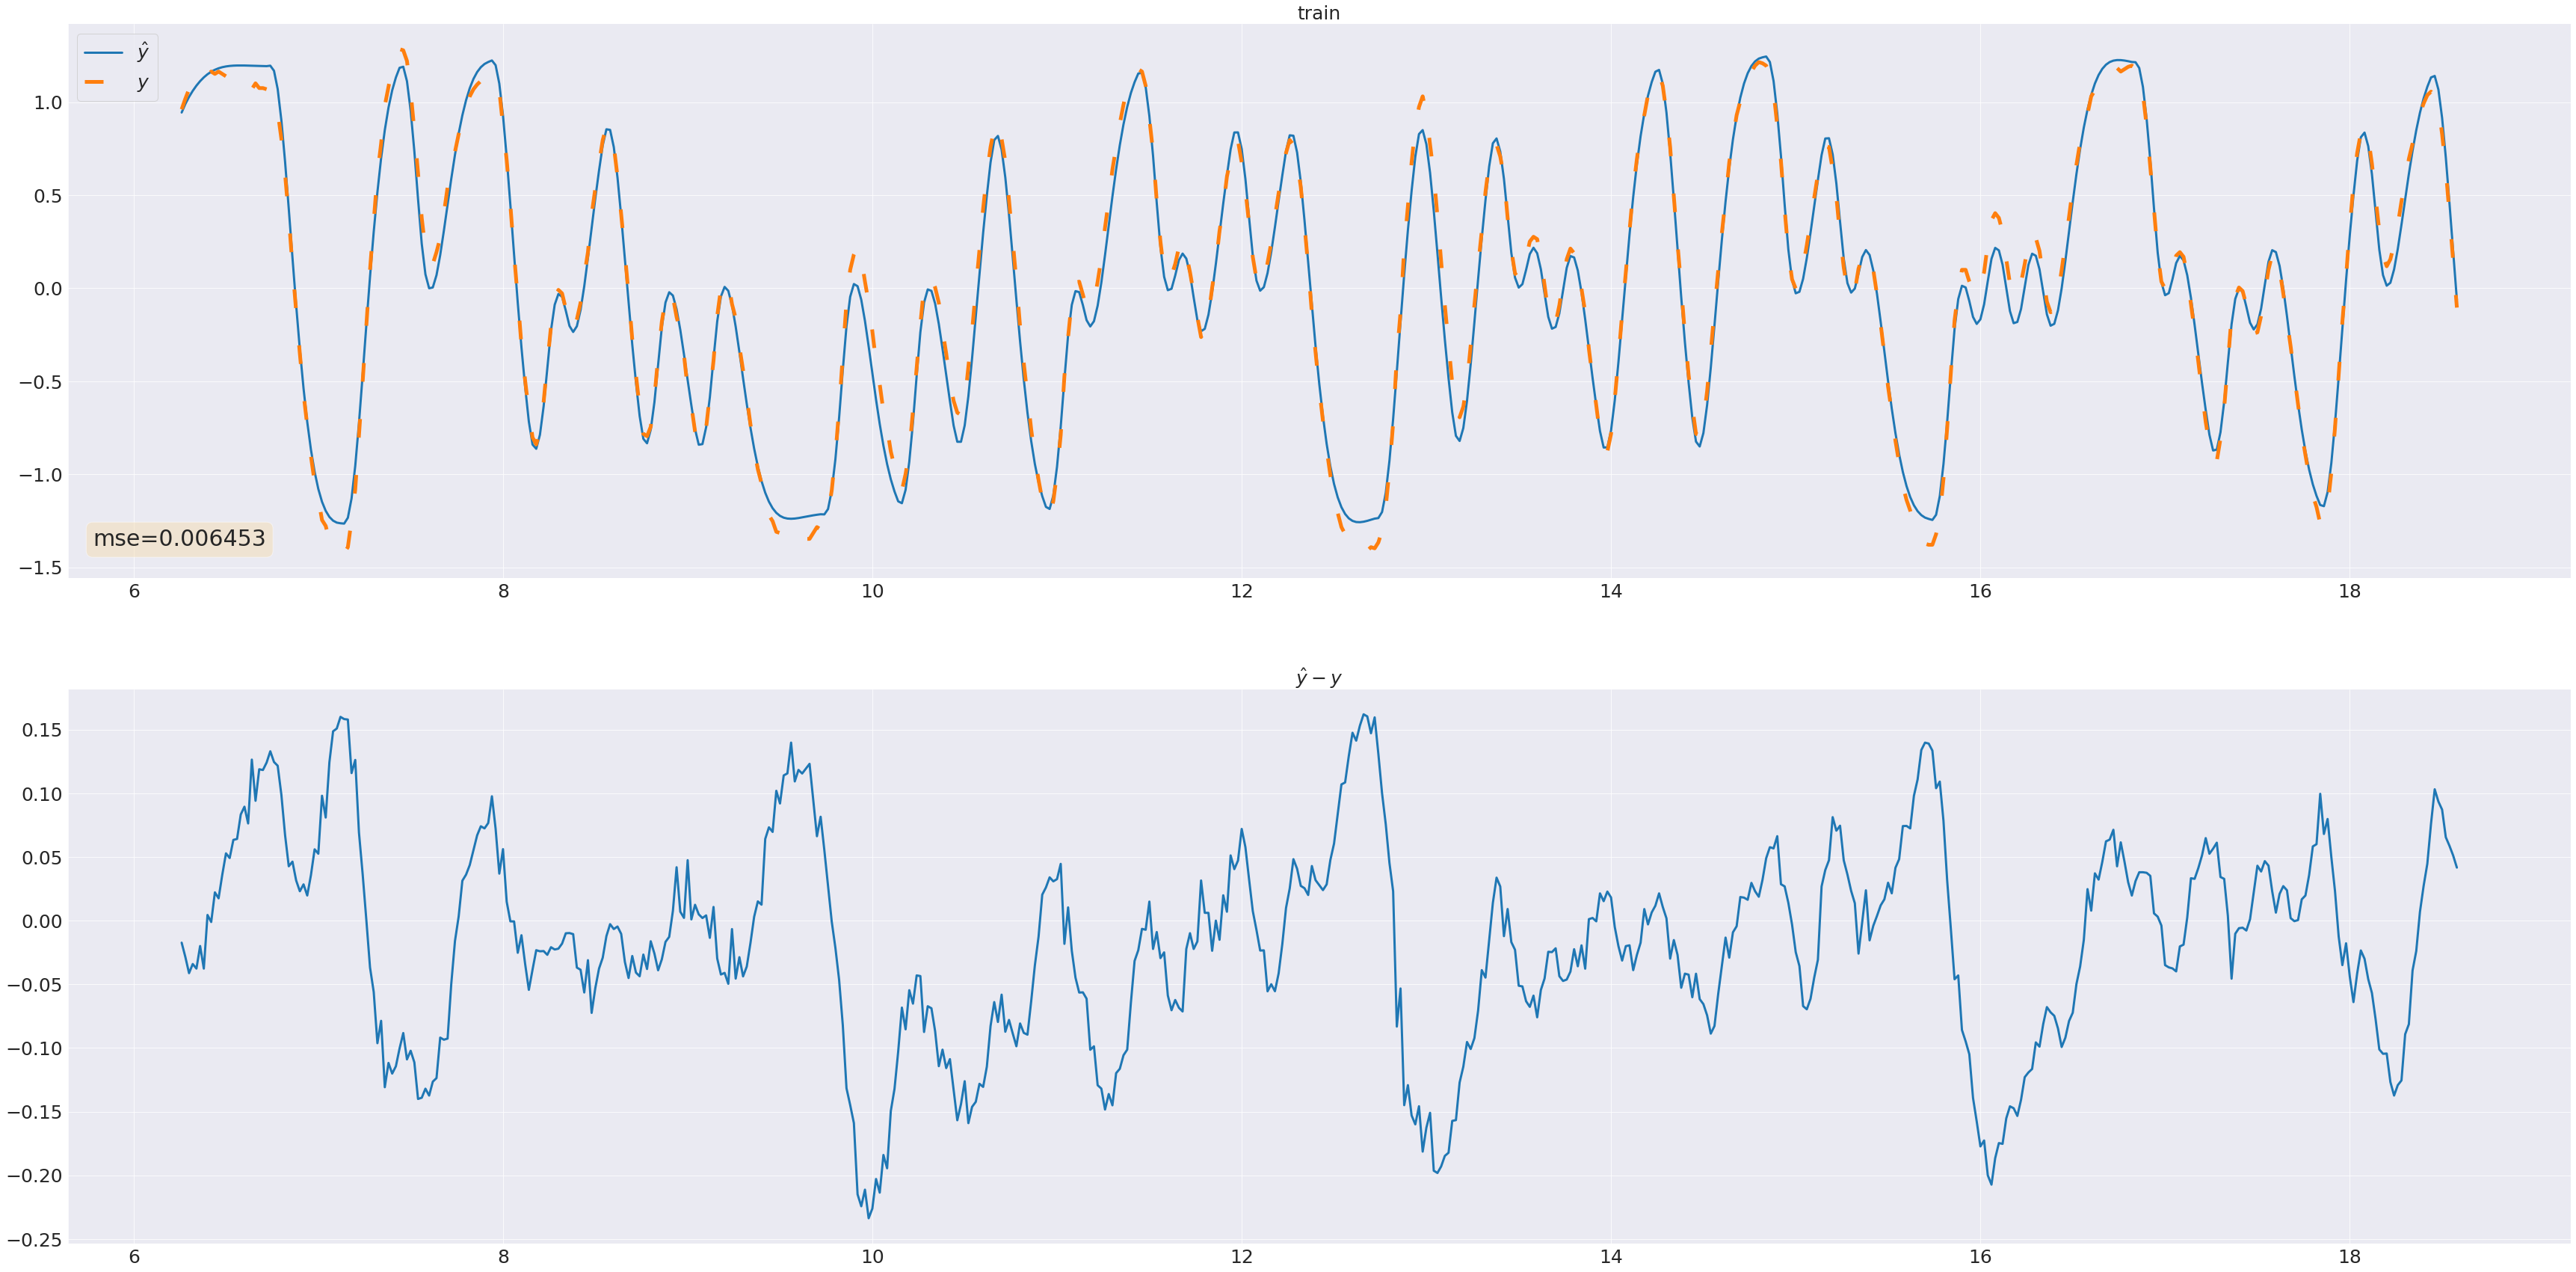

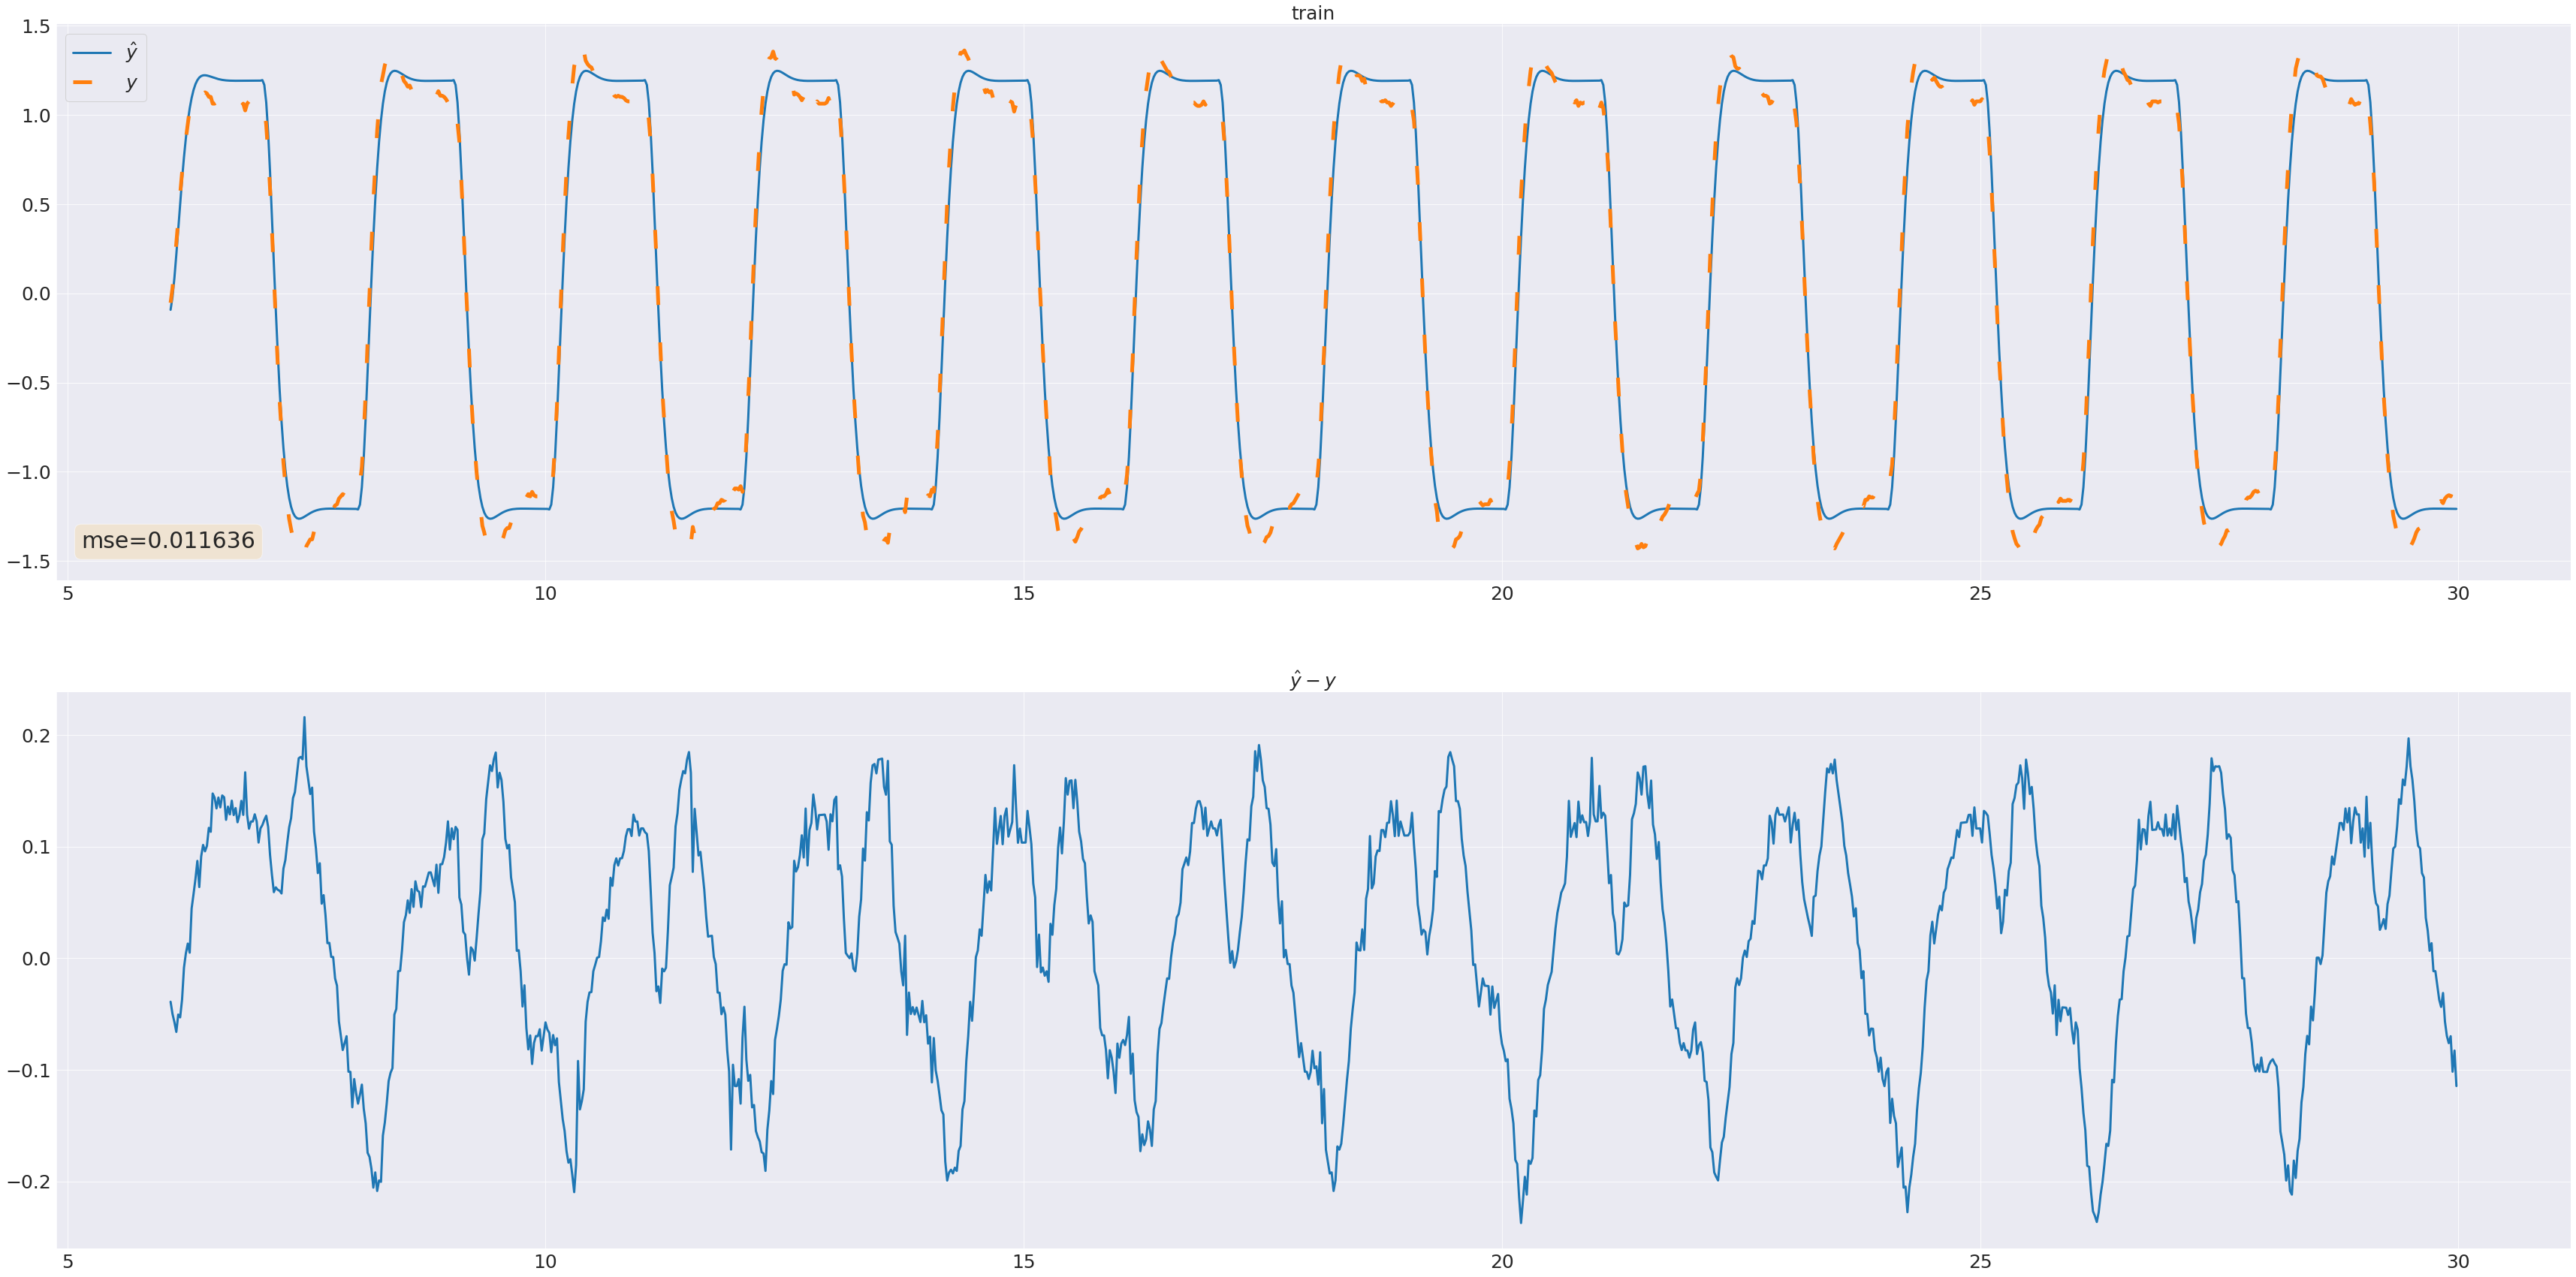

In [14]:
df_2222 = copy.deepcopy(df_222)
df_1111 = copy.deepcopy(df_111)

lagged_z_ = ['z__lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_2222['z__lag' + str(i)] = df_2222['z_'].shift(i)

df_2222 = df_2222.dropna()

# sovle IV by hand
Z = np.asarray(df_2222[lagged_z_ + lagged_u])
X = np.asarray(df_2222[lagged_y + lagged_u])
y = np.asarray(df_2222['y'])
theta_04 = np.linalg.inv(Z.T @ X) @ Z.T @ y

# simulate model on train data
df_2222['z__'] = simulate(theta_04, df_2222[lagged_y].iloc[0, :], df_2222[lagged_u])

# training error
mse_train_2222 = mean_squared_error(df_2222['z__'], df_2222['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_2222['time']), df_2222['z__'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_2222['time']), np.asarray(df_2222['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_2222,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_2222['time']), df_2222['z__'] - df_2222['y'])
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

# simulate model on test data
df_1111['z__'] = simulate(theta_04, df_1111[lagged_y].iloc[0, :], df_1111[lagged_u])
#df_11['x'] = np.asarray(df_11[lagged_y+lagged_u]) @ theta_02

# training error
mse_train_1111 = mean_squared_error(df_1111['z__'], df_1111['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_1111['time']), df_1111['z__'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_1111['time']), np.asarray(df_1111['y']), label=r'$y$', linestyle=(0, (5, 10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_1111,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_1111['time']), df_1111['z__'] - np.asarray(df_1111['y']))
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)
plt.show()

### Both the training and validation error increase...